In [1]:
%matplotlib inline
%run ../python/oana_setup.py

/hdd500/home/e16e1fjobssimtof/e1f/skim/3????.root
/hdd500/home/e16e1fjobssimtof/e1f/skim/3xxxx_run.root
run.lum(=l)
runb.lb(=l)
tpipf.tpilf(=lf)
h10.tpipf(=pf)
h10.run(=r)
h10.tkin(=k)
elist_fid_mm_[123]=el[123]
loaded acc.cpp
loaded fid.cpp
loaded particle-constants.h
loaded Fid instance
loaded infid.C
loaded eff.cpp
recompiling h10t3pi_sel.C...


... done.
Fid::Instance() loaded	 from /home/ephelps/projects/phys-ana-omega/fid.cpp	 with parameters from /home/ephelps/projects/phys-ana-omega/input/fid.parms
infid() loaded	 from /home/ephelps/projects/phys-ana-omega/infid.C
h10 aliases: c, mpip, bifpip, dtifpip, sf	fidpass, fidpass[e,p,pip,pim]	top[1,2,3]pass, mmthreshpass, mmpi0pass	ccpass


In [2]:
import rootpy as rp
import math
from scipy import interpolate
import numpy as np
import os
MASS_P = 0.93827203
tops = {1:(el1, 'xsect_manual2.root')}
top = 1    # default to topology 1
h10.SetEntryList(el1)

def create_hists(fn=tops[top][1], el=tops[top][0]):
    global h10
    h10.SetEntryList(el)
#     h10.SetAlias("Q2", "(2*5.499*p[0]*(1-cz[0]))")
#     h10.SetAlias("W", "(sqrt(0.938*0.938+2*0.938*(5.499-p[0])-Q2))")
#     h10.SetAlias("ephi", "(1.0*atan2(cy[0],cx[0]))")
#     h10.SetAlias("nu", "((W*W-0.938*0.938+Q2)/(2*0.938))")
#     h10.SetAlias("eps", "(1.0/(1+2*(Q2+nu*nu)/(4*5.499*p[0]-Q2))z)")
#     h10.SetAlias("vgflux", "(0.0073*W*(W*W-0.938*0.938)/(4*3.14159*5.499*5.499*0.938*0.938*Q2*(1-eps)))")
    h10.SetAlias("mmp0", "(nu+0.938-sqrt(0.938*0.938+p[1]*p[1]))")
    h10.SetAlias("mmp1", "(-p[0]*cx[0]-p[1]*cx[1])")
    h10.SetAlias("mmp2", "(-p[0]*cy[0]-p[1]*cy[1])")
    h10.SetAlias("mmp3", "(5.499-p[0]*cz[0]-p[1]*cz[1])")
    h10.SetAlias("mmppip0", "(mmp0-sqrt(p[2]^2+0.139^2))")
    h10.SetAlias("mmppip1", "(mmp1-p[2]*cx[2])")
    h10.SetAlias("mmppip2", "(mmp2-p[2]*cy[2])")
    h10.SetAlias("mmppip3", "(mmp3-p[2]*cz[2])")
#     h10.SetAlias("mmp", "sqrt(mmp0^2-mmp1^2-mmp2^2-mmp3^2)")
    h10.SetAlias("mmppip_alt", "sqrt(mmppip0^2-mmppip1^2-mmppip2^2-mmppip3^2)")
    ht1q2w = rh1('-t1:Q2:W', hn='ht1q2w', cutstr='1/(accw8(W, Q2, ct, phi)*vgflux*0.891*19.844e6)', binning='(32,1.6,3.2, 9,1.0,5.5, 80,0,8)')
    hmq2w = rh1('mmp:Q2:W', hn='hmq2w', cutstr='1/(accw8(W, Q2, ct, phi)*vgflux*0.891*19.844e6)*(id[0]==11 && id[1]==2212 && id[2]==211 && nphe[cc[0]-1]>30 && mmppip_alt>0.3)', binning='(32,1.6,3.2, 9,1.0,5.5, 80, 0.4, 1.2)')
    hq2w = rh1('Q2:W', hn='hq2w', cutstr='1/(accw8(W, Q2, ct, phi)*vgflux*0.891*19.844e6)', binning='(320,1.6,3.2, 80,1,5.5)')
    print(ht1q2w.GetEntries())
    print(hmq2w.GetEntries())
    #with ropen('simulation_shaping.root', 'recreate') as fout:
    with ropen(fn, 'recreate') as fout:
        [h.Clone().Write(h.GetName()) for h in [ht1q2w, hmq2w, hq2w]]
    return (ht1q2w, hmq2w, hq2w)

def get_hists(fn=tops[top][1], el=tops[top][0]):
    global h10
    h10.SetEntryList(el)
    ht1q2w, hmq2w, hq2w = _,_,_
    if (os.path.exists(fn)):
        with ropen(fn, 'read') as fin:
            ht1q2w, hmq2w, hq2w = [asrootpy(h.Clone()) for h in [fin.ht1q2w, fin.hmq2w, fin.hq2w]]
            [h.SetDirectory(0) for h in [ht1q2w, hmq2w, hq2w]]
            fin.Close()
    else:
        ht1q2w, hmq2w, hq2w = create_hists(fn, el)
    return (ht1q2w, hmq2w, hq2w)

ht1q2w, hmq2w, hq2w = get_hists()

def get_projs(h3=hmq2w, hntmpl='mass_%d_%d', zintrange=(0.750, 0.793), minint=1000):
    wax, q2ax, zax = h3.GetXaxis(), h3.GetYaxis(), h3.GetZaxis()
    zlobin, zhibin = zax.FindBin(zintrange[0]), zax.FindBin(zintrange[1])+1
    hms = [asrootpy(h3.ProjectionZ(hntmpl%(1000*wax.GetBinCenter(wbin), 1000*q2ax.GetBinCenter(q2bin)),
                                    wbin, wbin+1, q2bin, q2bin+1))
            for q2bin in range(1, q2ax.GetNbins())
            for wbin in range(1, wax.GetNbins())
            if h3.Integral(wbin, wbin+1, q2bin, q2bin+1, zlobin, zhibin) > minint]
        
    zax.SetRange(0,-1)
    return hms

def bgfun(x, p):
    pol2 = p[0]+p[1]*x[0]+p[2]*x[0]*x[0]
    #print(p[3], x[0], p[4])
    drop = 1 - math.erf((x[0]-p[3])/p[4])
    if (x[0] > 0.5 and x[0] < 0.6) or (x[0] > 0.7 and x[0] < 0.92): r.TF1.RejectPoint()
    return pol2*drop/2

def drop(x, p):
    return 1 - math.erf((x[0]-p[0])/p[1])

def gausdrop(x, p):
    gaus = p[0]*math.exp(-0.5*pow(((x[0]-p[1])/p[2]), 2))
    return gaus*drop(x, [p[3],p[4]])/2

def fitfun(x, p):
    pol2 = p[0]+p[1]*x[0]+p[2]*x[0]*x[0]
    gaus = p[5]*math.exp(-0.5*pow(((x[0]-p[6])/p[7]), 2))
    return (gaus+pol2)*drop(x, [p[3],p[4]])/2
def fit_mmp(h, fout=None):
    '''
    Fit histogram with (gauss+pol2)*(erf cutoff).
    Return tuple of W, Q2, histogram, function, fit parameters, chi2, FCstatu.
    + Cutoff parameters estimated from phase space edge from W.
    + Background parameters estimated by fitting with signal, skipping signal region.
    + Signal parameters estimated by subtracting initial background and fitting in
      vicinity of the omega mass mean.
    + Full histogram fitted with combined function.
    TODO:  add option to provide initial parameter estimates.
    '''
    result = []
    # ######### get W,Q2 bin information
    W, Q2 = h.GetName().split('_')[1:]
    W = float(W)/1000.0
    Q2 = float(Q2)/1000.0
    wlow, whigh = W-0.025, W+0.025  # W bins are 50 MeV
    # ######### calculate MMp phase space edge range
    mmpax = h.GetXaxis()
    x0 = math.sqrt(wlow**2+MASS_P**2-2*wlow*MASS_P)
    x1 = math.sqrt(whigh**2+MASS_P**2-2*whigh*MASS_P)
    # ######### setup fit functions
    fgaus = r.TF1('fgaus', gausdrop, 0.4, 1.2, 5)
    fgaus.SetParameters(r.Double(20), r.Double(0.783), r.Double(0.20), r.Double((x1+x0)*0.5), r.Double(x1-x0))
    fgaus.SetParLimits(0, 0.01, 1e4)
    fgaus.SetParLimits(1, 0.773, 0.793)
    fgaus.SetParLimits(2, 0.011, 0.035)
    fgaus.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
    fgaus.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
    fbg = r.TF1('fbg', bgfun, 0.4, 1.2, 5)
    fbg.SetParameters(r.Double(0), r.Double(0), r.Double(0.02), r.Double((x1+x0)*0.5), r.Double(x1-x0))
    fbg.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
    fbg.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
    fbg.SetParLimits(2, 0.01, 1e9)
    # ######### fit background for parameter estimates
    h.Fit(fbg, '', 'goff', 0.4, 1.2)
    if True:  #r.gMinuit.fCstatu.startswith('CONV'):
        # ######### fit signal for parameter estimates
        wsig = h.Clone()
        wsig.Add(fbg, -1)
        sigint = wsig.Integral(mmpax.FindBin(0.76), mmpax.FindBin(0.80))
        sigint = sigint if sigint > 0 else h.Integral(mmpax.FindBin(0.76), mmpax.FindBin(0.80))
        fgaus.SetParLimits(0, 0.1*sigint, 2*sigint)
        wsig.Fit(fgaus, '', '', 0.76, 0.80)
        if True:  #r.gMinuit.fCstatu.startswith('CONV'):
            # ######### create combined signal-background function and set parameters
            fsigbg = r.TF1('fsigbg', fitfun, 0.4, 1.2, 8)
            fsigbg.SetParameters(r.Double(0), r.Double(0), r.Double(0.02), r.Double((x1+x0)*0.5), r.Double(x1-x0), r.Double(20), r.Double(0.783), r.Double(0.022))
            fsigbg.SetParameters(fbg.GetParameter(0), fbg.GetParameter(1), fbg.GetParameter(2),
                                 fbg.GetParameter(3), fbg.GetParameter(4),
                                 fgaus.GetParameter(0), fgaus.GetParameter(1), fgaus.GetParameter(2))
            fsigbg.SetParLimits(2, 0.0001, 1e9)
            fsigbg.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
            fsigbg.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
            #fsigbg.SetParLimits(3,0.65,2)
            #fsigbg.SetParLimits(4,0.03, 0.2)
            fsigbg.SetParLimits(5, 0.1*sigint, 2*sigint)
            fsigbg.SetParLimits(6, 0.773, 0.793)
            fsigbg.SetParLimits(7, 0.011, 0.035)
            # ######### fit signal and background
            h.Fit(fsigbg, '', 'goff', 0.4, 1.2)
            if True:  #r.gMinuit.fCstatu.startswith('CONV'):
                q = fsigbg.GetChisquare()/fsigbg.GetNDF() if fsigbg.GetNDF() > 0 else -1
                result += [W,Q2]
                result.append(h)
                result.append(h.GetListOfFunctions()[0])
                result.append(tuple([fsigbg.GetParameter(ipar) for ipar in range(0,8)]))
                result.append(q)
                result.append(r.gMinuit.fCstatu)
                if fout is not None: fout.WriteObject(h, h.GetName())
    return tuple(result) if result is not None else None

ERROR:ROOT.TChain.SetEntryList] No list found for the trees in this chain
ERROR:ROOT.TChain.SetEntryList] No list found for the trees in this chain
ERROR:ROOT.TChain.SetEntryList] No list found for the trees in this chain


24919391.0
5977142.0


## fit mass distribution for each $W, Q^{2}$

In [3]:
# hms = get_projs(hmq2w, minint=0)

In [4]:
# hms[40:43][0]

In [5]:
#r.gMinuit.mnexcm("SET NOWarnings",0,0,0);
hms = get_projs(hmq2w, minint=0)
[h.Scale(1/0.025) for h in hms]
fout = ropen('xsect_manual_bgfits.root','recreate')
results = [result for result in [fit_mmp(h, fout) for h in hms] if result is not None]

INFO:ROOT.TCanvas.MakeDefCanvas]  created default TCanvas with name c1


## signal+background normalized $\chi^{2}$

137:21:158


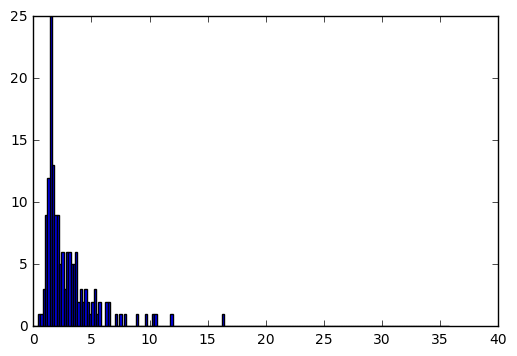

In [6]:
plt.hist([result[5] for result in results], bins=np.arange(0,36,0.2))
# hbads = [res for res in results if not res[4].startswith('CONV') or res[3] > 5]
# hgoods = [res for res in results if not (not res[4].startswith('CONV') or res[3] > 5)]
hbads = [res for res in results if res[5] > 5]
hgoods = [res for res in results if not res[5] > 5]
print('%d:%d:%d' % (len(hgoods), len(hbads), len(results)))

## $\mu$ and $\sigma$ signal parameter

(look into proton momentum distributions in each $W,Q^{2}$ to see if there's a connection with the lowering of $\mu$ with increasing $W$)... **energy loss**

In the omega mass distribution ($MM_{p}$), energy loss grows more significant as $W$ increases and as $Q^{2}$ decreases, pushing the mean lower.

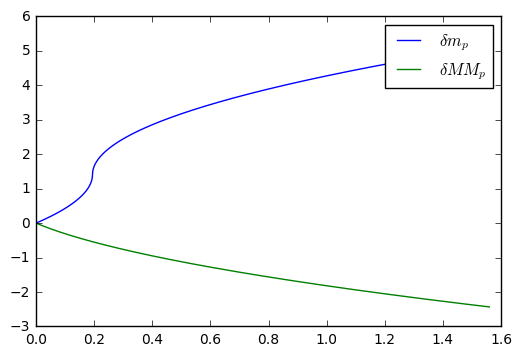

In [7]:
#rc('text', usetex=True)
MASS_E, MASS_P = 5.11e-4, 0.9382720
lvE0, lvE1, lvP0, lvP1 = r.TLorentzVector(), r.TLorentzVector(), r.TLorentzVector(), r.TLorentzVector()
lvE0.SetXYZM(0, 0, 5.497, MASS_E)
lvE1.SetXYZM(-0.530879,0.5977996,1.6425339,MASS_E)
lvP0.SetXYZM(0,0,0,MASS_P)
lvP1.SetXYZM(0.2381055,0.0006208,1.5412714,MASS_P)
def lvLoss(deltaE):
    ret = r.TLorentzVector()
    ret.SetXYZM(0,0,-deltaE, 0)
    return ret
lvq = lvE0-lvE1
lvw = lvq+lvP0
mmp = (lvw-lvP1).M()
X = np.linspace(0,lvP1.P(),1000)
X = list(zip(X,X))
Y = [(mmp-(lvw-lvP1-lv).M(),MASS_P-(lvP1+lv).M()) for lv in [lvLoss(dE[0]) for dE in X]]
plt.plot(X,Y)
plt.legend([r'$\delta m_{p}$', r'$\delta MM_{p}$'])

0.782689371549 0.0236839631729


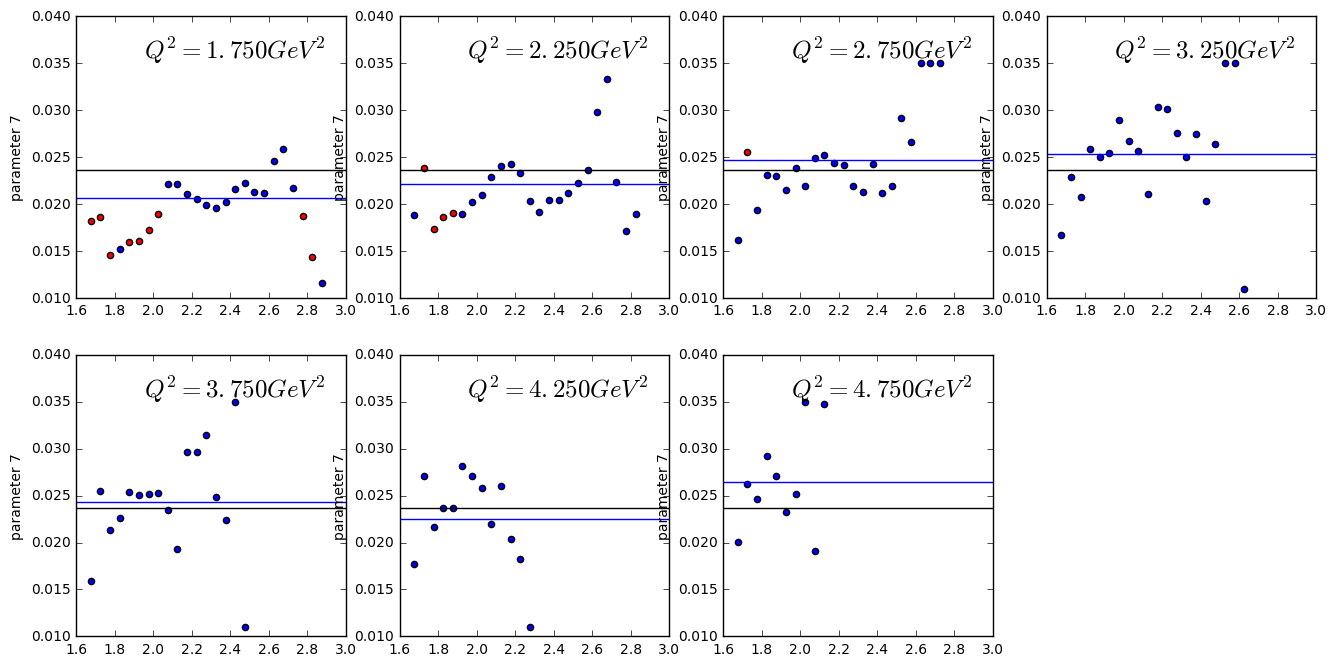

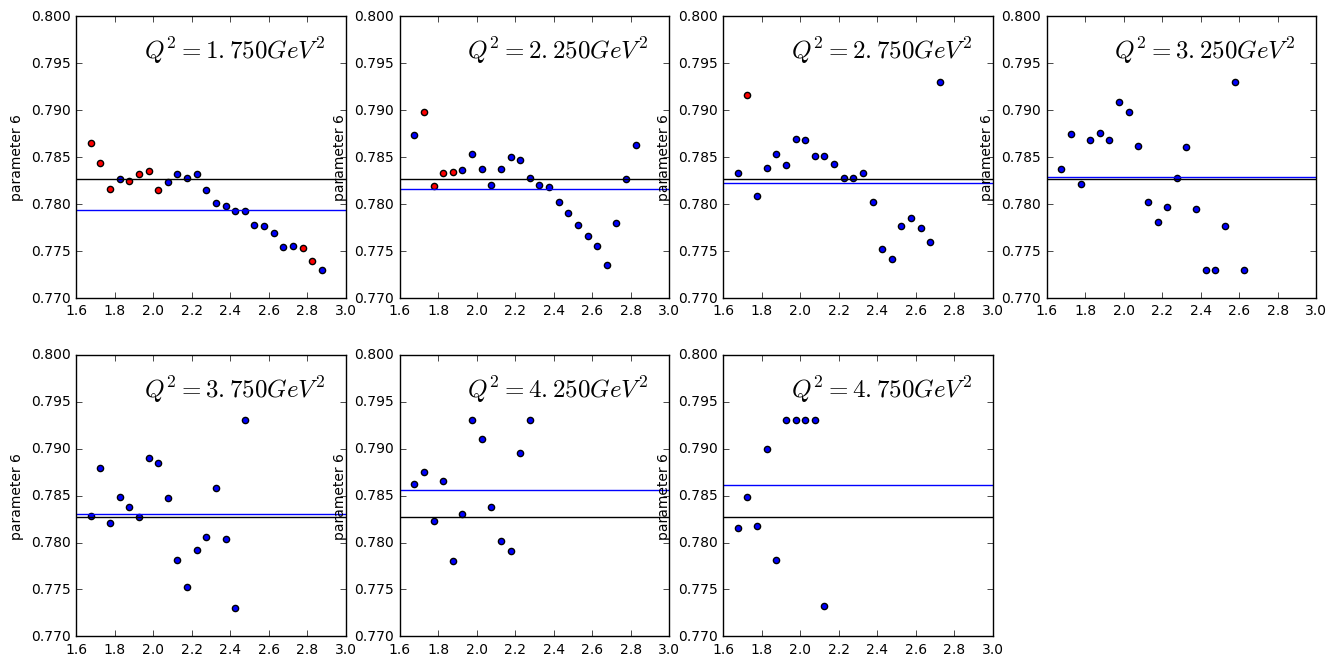

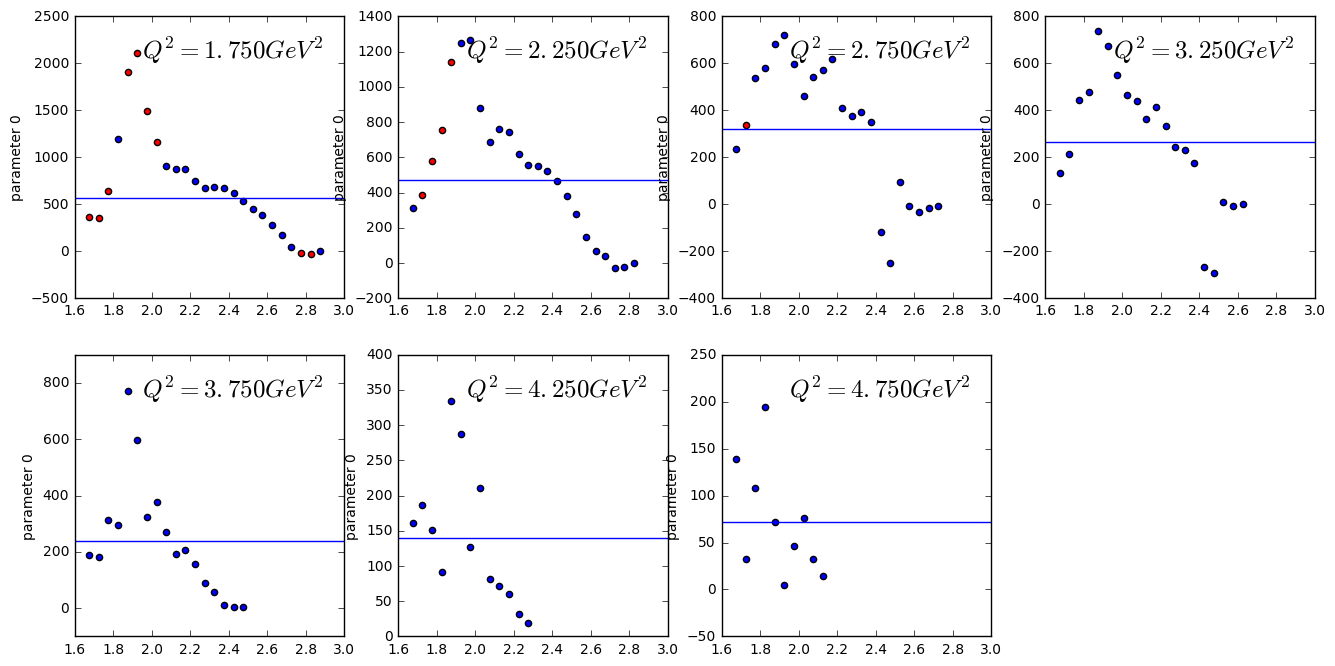

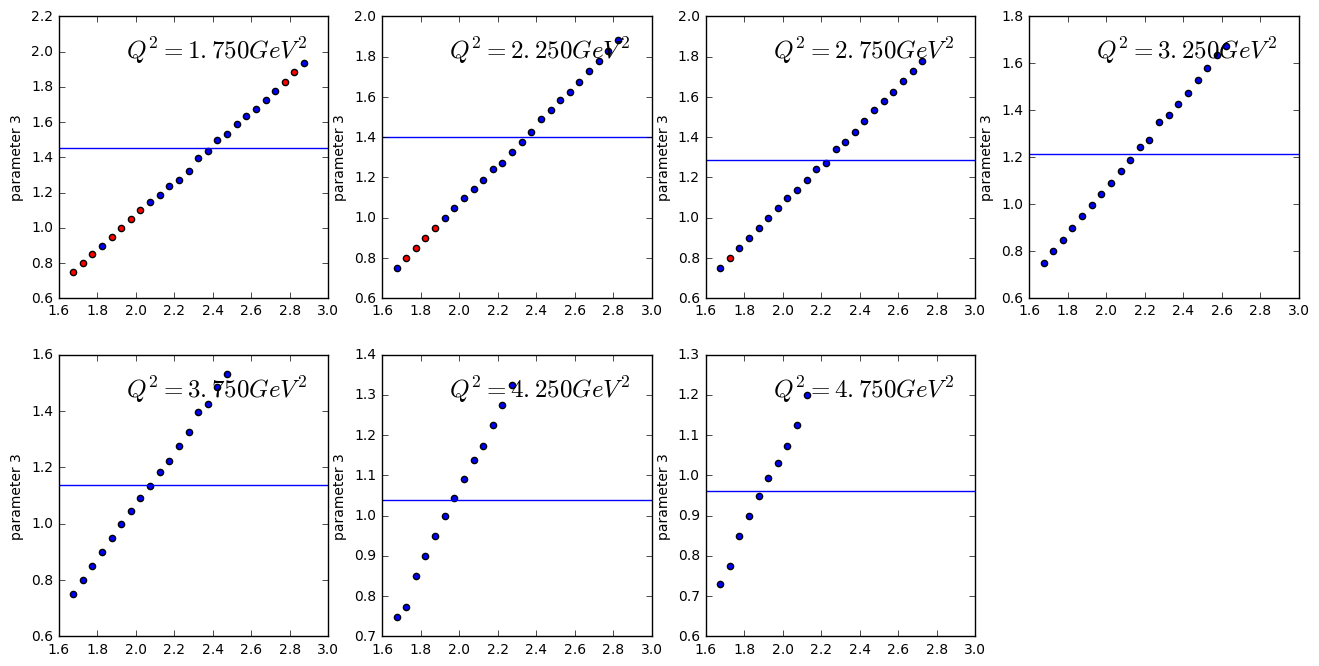

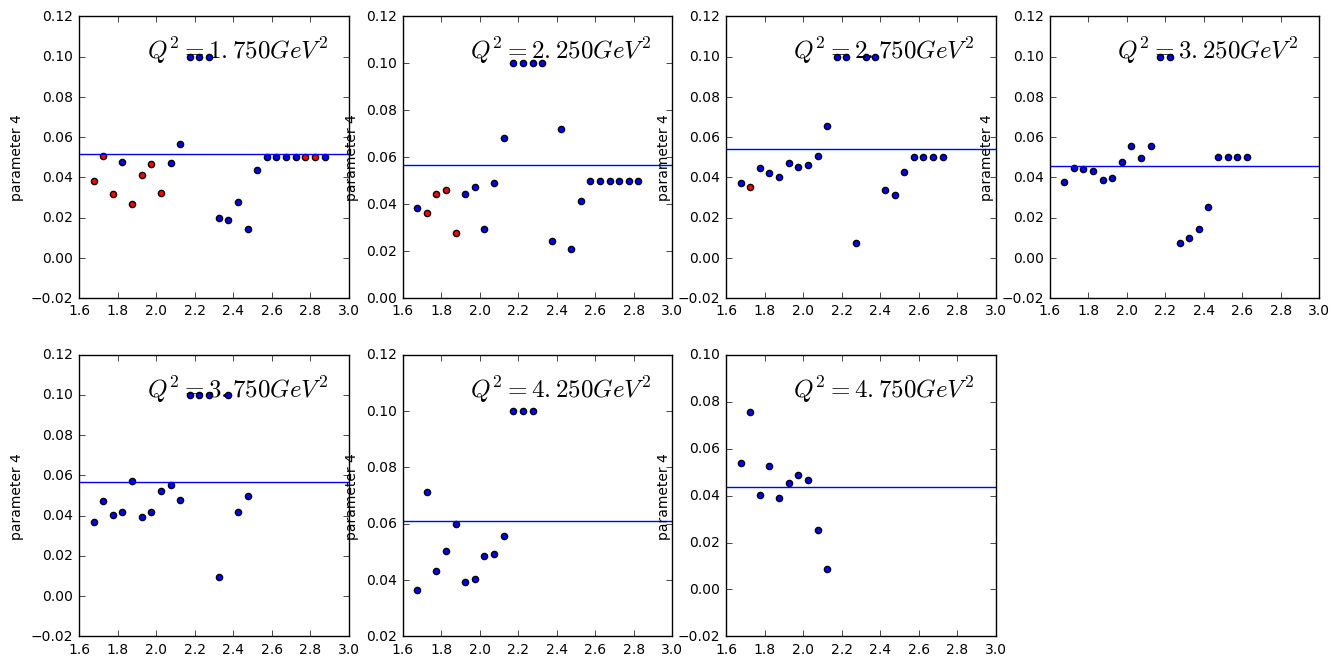

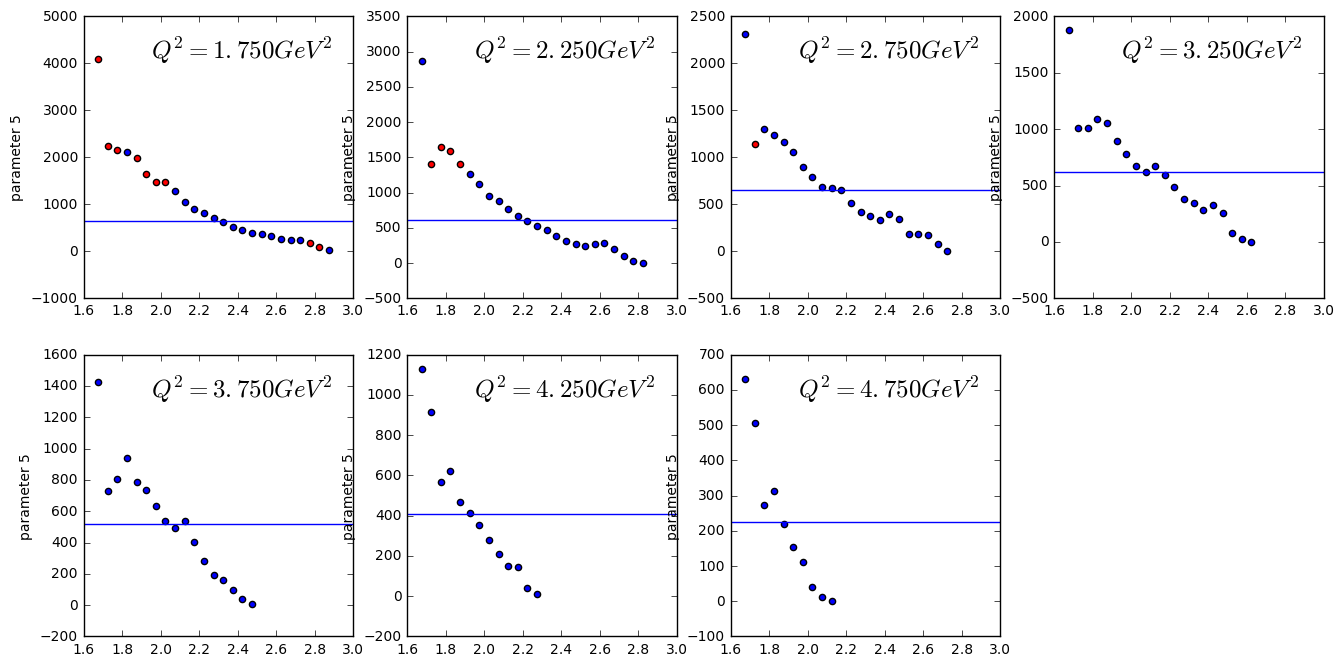

In [8]:
q2s = np.unique([h[1] for h in hgoods if h[1]>=1.5])
ws = np.unique([h[0] for h in hgoods if h[1]>=1.5])
colorcycle = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
sigmas = [s for s in [h[4][7] for h in hgoods if h[1] in q2s]]
masses = [s for s in [h[4][6] for h in hgoods if h[1] in q2s]]
avgS = np.average(sigmas)
avgM = np.average(masses)
print(avgM,avgS)
def drawparms(ipar, avg=None, ylims=None, xlims=(1.6,3.0), fig=None):
    for i, q2 in enumerate(q2s):
        if fig is None: fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(2,4,i+1)
        W = [w for w in [h[0] for h in hgoods if h[1]==q2]]
        S = [s for s in [h[4][ipar] for h in hgoods if h[1]==q2]]
        plt.scatter(W, S, c='b')
        plt.axhline(np.average(S), color='b')
        W = [w for w in [h[0] for h in hbads if h[1]==q2]]
        S = [s for s in [h[4][ipar] for h in hbads if h[1]==q2]]
        plt.scatter(W, S, c='r')
        if avg is not None:
            plt.axhline(avg, color='k')
        if ylims is not None: plt.ylim(*ylims)
        plt.xlim(*xlims)
        plt.ylabel('parameter %d'%ipar)
        plt.text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%q2, fontsize=18, transform=ax.transAxes)

fig = plt.figure(1, figsize=(16,8))
drawparms(7, avgS, (0.01,0.04))
fig2 = plt.figure(2, figsize=(16,8))
drawparms(6, avgM, (0.77,0.8))
for ipar in range(0,6):
    drawparms(ipar)



In [9]:
results[0]

(1.675,
 1.25,
 Hist('mass_1675_1250'),
 <ROOT.TF1 object ("fsigbg") at 0x165c19b0>,
 (1415.3163487887439,
  -7233.5197405697445,
  9639.576883070515,
  0.7492279699983104,
  0.03747062815463946,
  14951.84637027692,
  0.7831760464836244,
  0.015943649317831193),
 7.841891672741714,
 'CONVERGED ')

In [10]:
import operator as op
xsect_wq2 = []
fgaus = r.TF1('fgaus', gausdrop, 0.4, 1.2, 5)
for res in results:
    if res[5]<5: #res[6] == 'CONVERGED ' and res[5] < 5:
        gpars = res[4][5:]+res[4][3:5]
        fgaus.SetParameters(r.Double(gpars[0]), r.Double(gpars[1]),
                            r.Double(gpars[2]), r.Double(gpars[3]),
                            r.Double(gpars[4]))
        xsect = np.sum([fgaus.Eval(x) for x in res[2].x()])
        xsect_wq2.append((res[0],res[1],xsect))
#print(results[n][0], results[n][1], np.sum([fgaus.Eval(mmp) for mmp in results[n][2].x() if mmp > 0.7 and mmp < 0.9]))

In [11]:
W, Q2, xsect = zip(*xsect_wq2)

In [12]:
import pandas as pd

In [13]:
needcorr = [(2.925,1.75), (2.875,1.75), (2.825,1.75),
            (2.825,2.25), (2.775,2.25), (2.725,2.25),
            (2.725,2.75), (2.675,2.75), (2.625,2.75),
            (2.625,3.25), (2.575,3.25), (2.525,3.25), (2.475,3.25),
            (2.475,3.75), (2.425,3.75), (2.375,3.75), (2.325,3.75),
            (2.325,4.25), (2.275,4.25), (2.225,4.25), (2.175,4.25), (2.125,4.25),
            (2.125,4.75), (2.075,4.75), (2.025,4.75), (1.975,4.75), (1.925,4.75)]
dt = 0.001
rd = lambda x: round(x,3)
fuzeq = lambda x, y: rd(x)==rd(y)
needscorr = [(rd(W[i]),rd(Q2[i])) in [(rd(w),rd(q2)) for (w,q2) in needcorr] for i in range(0,len(W))]

d = {'W':W, 'Q2':Q2, 'xsect':xsect, 'needsbincorr':needscorr}
df = pd.DataFrame(data=d)

In [14]:
print(sorted(df.Q2.unique()))
print(sorted(df.W.unique()))
q2edges=[(1.5,2), (2,2.5), (2.5,3), (3,3.5), (3.5,4), (4,5)]

[1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75]
[1.675, 1.7250000000000001, 1.7749999999999999, 1.825, 1.875, 1.925, 1.9750000000000001, 2.0249999999999999, 2.0750000000000002, 2.125, 2.1749999999999998, 2.2250000000000001, 2.2749999999999999, 2.3250000000000002, 2.375, 2.4249999999999998, 2.4750000000000001, 2.5249999999999999, 2.5750000000000002, 2.625, 2.6749999999999998, 2.7250000000000001, 2.7749999999999999, 2.8250000000000002, 2.875, 2.9750000000000001]


In [15]:
dfm = pd.read_table('/home/ephelps/dropbox/Notebooks/omega/Projects/Omega/Cross-sections/Morand/xsect_integrated_morand.txt')

In [16]:
sorted(dfm.Q2.unique())

[1.7250000000000001,
 1.7519999999999998,
 1.7849999999999999,
 2.0419999999999998,
 2.0499999999999998,
 2.0550000000000002,
 2.3199999999999998,
 2.3500000000000001,
 2.371,
 2.6389999999999998,
 2.6499999999999999,
 2.6510000000000002,
 2.9139999999999997,
 2.9500000000000002,
 2.968,
 3.2949999999999999,
 3.3500000000000001,
 3.3569999999999998,
 3.8069999999999999,
 3.8500000000000001,
 3.8819999999999997,
 4.3069999999999995,
 4.3499999999999996,
 4.3520000000000003,
 4.7649999999999997,
 4.8499999999999996]

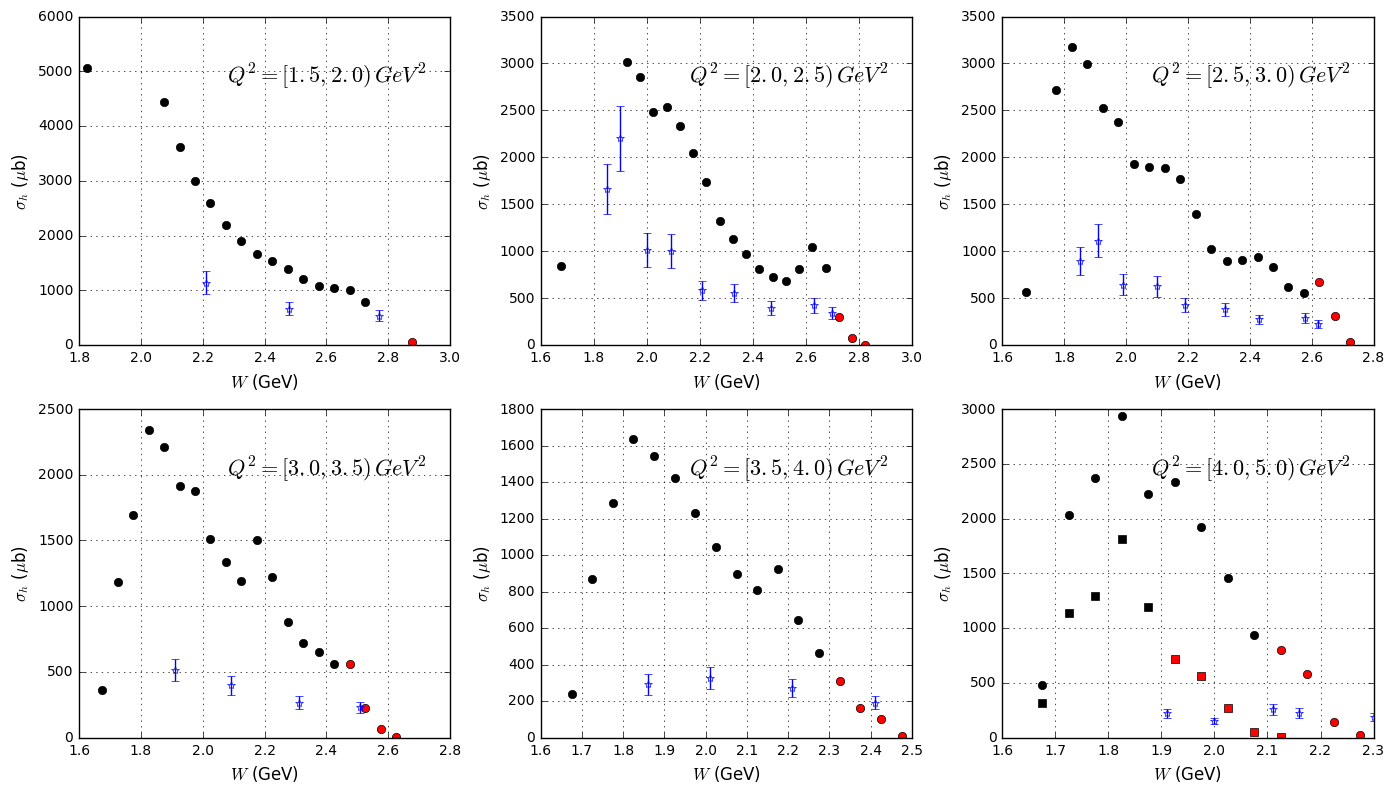

In [17]:
fctrs = [1.6, 2, 2.25, 3, 3.25, 1.25]
fig = plt.figure(dpi=1200, figsize=(14, 8))
fmtcycle = ['ko', 'ks', 'k^', 'kv']
fmtcycle2 = ['ro', 'rs', 'r^', 'rv']
for pad, q2range in enumerate(q2edges,1):
    picks = (df.Q2>=q2range[0]) & (df.Q2<q2range[1])
    fig.add_subplot(2,3,pad)
    lq2s = df.Q2[picks].unique()
    plt.text(0.4, 0.8, '$Q^{2} = [%.1f,%.1f)\,GeV^{2}$'%(q2range[0],q2range[1]), fontsize=16, transform=fig.axes[pad-1].transAxes)
    for i, q2 in enumerate(lq2s):
        picks = (df.Q2 > q2-dt) & (df.Q2 < q2+dt)
        picks1 = (picks) & (~df.needsbincorr)
        picks2 = (picks) & (df.needsbincorr)
        plt.plot(df.W[picks1], df.xsect[picks1]/fctrs[pad-1], fmtcycle[i])
        plt.plot(df.W[picks2], df.xsect[picks2]/fctrs[pad-1], fmtcycle2[i])
    picks = (dfm.Q2 >= q2range[0]) & (dfm.Q2 < q2range[1])
    plt.errorbar(dfm.W[picks].values, dfm.xsect[picks].values, dfm.error[picks].values, fmt='b*', fillstyle='none')
    plt.ylim(0)
    plt.ylabel('$\sigma_h$ ($\mu$b)', fontsize=12)
    plt.xlabel('$W$ (GeV)', fontsize=12)
    plt.grid()
plt.tight_layout()

## mass distribution fits

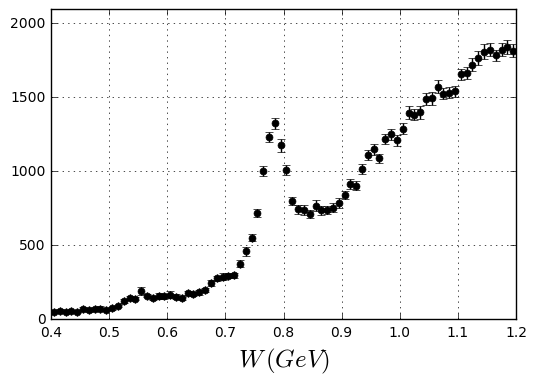

In [18]:
rplt.errorbar([results[38][2]], xerr=False)
plt.xlabel(r'$W\,(GeV)$', fontsize=18)
#yticks([])
plt.xticks(np.arange(0.4, 1.21, 0.1))
plt.grid()

In [19]:
plt.rc('text', usetex=True)
def drawpub(n, hgbs, i):
    ax = axes[i-1]
    rplt.errorbar([hgbs[n][2]], xerr=False, axes=ax, marker='')
    ax.set_xlabel(r'$MM_X [epX]\,(GeV)$') #, fontsize=18)
    #yticks(arange(2.5e6,ylim()[1],2.5e6))
    #ylim(0,2e7)
    if i < 3:
        ymax = ax.get_ylim()[1]*1.25
        ax.set_ylim(0,ymax)
    else:
        ax.set_ylim(0)
    ax.set_xticks(np.arange(0.4, 1.21, 0.1))
    if i == 1: ax.set_ylabel(r'$Yield$') #, fontsize=14)
    ax.grid()
    ax.plot(np.linspace(0.4,1.2,500), [hgbs[n][3].Eval(x) for x in np.linspace(0.4,1.2,500)], linewidth=3, color='k', alpha=0.5)
    fgaus = r.TF1('fgaus', gausdrop, 0.4, 1.2, 5)
    fbg = r.TF1('fbg', bgfun, 0.4, 1.2, 5)
    gpars = hgbs[n][4][5:]+hgbs[n][4][3:5]
    fgaus.SetParameters(r.Double(gpars[0]), r.Double(gpars[1]),
                        r.Double(gpars[2]), r.Double(gpars[3]),
                        r.Double(gpars[4]))
    fbg.SetParameters(*[r.Double(p) for p in hgbs[n][4][0:5]])
    ax.plot(np.linspace(0.4,1.2,500), [fgaus.Eval(x) for x in np.linspace(0.4,1.2,500)], linewidth=2, color='g')
    ax.plot(np.linspace(0.4,1.2,500), [fbg.Eval(x) for x in np.linspace(0.4,1.2,500)], linewidth=2, color='r', linestyle='--')
#     plt.text(0.79, 0.45, '$W = %.3f\,GeV$\n$Q^{2} = %.3f\,GeV^{2}$'%(hgbs[n][0],hgbs[n][1]), transform=fig.axes[i-1].transAxes, rotation=90)
    ax.text(0.05, 0.75, '$W = %.3f\,GeV$\n$Q^{2} = %.3f\,GeV^{2}$'%(hgbs[n][0],hgbs[n][1]), transform=fig.axes[i-1].transAxes)
    ax.fill_betweenx(np.linspace(0,ax.get_ylim()[1],50), [0.6]*50, [0.74]*50, alpha=0.25, color='gray')
    ax.fill_betweenx(np.linspace(0,ax.get_ylim()[1],50), [0.85]*50, [0.99]*50, alpha=0.25, color='gray')
    ax.yaxis.major.formatter.set_powerlimits((0,0)) 
    print(hgbs[n][0], hgbs[n][1], np.sum([fgaus.Eval(mmp) for mmp in hgbs[n][2].x() if mmp > 0.7 and mmp < 0.9]))
ns = reversed([n+32 for n in [38, 25, 23]])
# fig = plt.figure(figsize=(6.5,2)) # (14,4))
fig, axes = plt.subplots(1, 3, gridspec_kw={'wspace':0.1}, figsize=(6.5,2))
for i, n in enumerate(ns,1):
    ax = axes[i-1]
    drawpub(n,results, i)
    ax.set_yticklabels([])
    ax.set_ylim(0)
    if i < 3:
        ax.set_xlim(0.4, 1.195)
        ax.set_xticklabels([r'$0.4$', r'', r'$0.6$', r'', r'$0.8$', r'', r'$1.0$', r''])
    else:
        ax.set_xticklabels([r'$0.4$', r'', r'$0.6$', r'', r'$0.8$', r'', r'$1.0$', r'', r'$1.2$'])
# plt.tight_layout()
fig.savefig('evt_sel_top_1_fitsamples_e1f.pdf', bbox_inches='tight')
#plt.savefig('fit_samples.pdf')
#plt.savefig('fit_samples.png')
# for (i, w, q2) in [(i, float(res[0]), float(res[1])) for (i, res) in enumerate(results)]:
#     if q2==1.75: #(w>=1.63 and w<=1.8):
#         print(i,w,q2)
#         drawsample(i,results)

1.825 2.25 7423.92798744
1.925 2.25 6028.69803682
2.575 2.25 1619.20647927


In [33]:
plt.rc('text', usetex=True)
def drawpub(n, hgbs, i):
    rplt.errorbar([hgbs[n][2]], xerr=False)
    plt.xlabel(r'$MM_p\,(GeV)$', fontsize=18)
    #yticks(arange(2.5e6,ylim()[1],2.5e6))
    #ylim(0,2e7)
    plt.xticks(np.arange(0.4, 1.21, 0.1))
    if i == 1: plt.ylabel(r'$\sigma$ ($\mu$b)', fontsize=14)
    plt.grid()
    plt.plot(np.linspace(0.4,1.2,500), [hgbs[n][3].Eval(x) for x in np.linspace(0.4,1.2,500)], linewidth=3, color='k', alpha=0.5)
    fgaus = r.TF1('fgaus', gausdrop, 0.4, 1.2, 5)
    fbg = r.TF1('fbg', bgfun, 0.4, 1.2, 5)
    gpars = hgbs[n][4][5:]+hgbs[n][4][3:5]
    fgaus.SetParameters(r.Double(gpars[0]), r.Double(gpars[1]),
                        r.Double(gpars[2]), r.Double(gpars[3]),
                        r.Double(gpars[4]))
    fbg.SetParameters(*[r.Double(p) for p in hgbs[n][4][0:5]])
    plt.plot(np.linspace(0.4,1.2,500), [fgaus.Eval(x) for x in np.linspace(0.4,1.2,500)], linewidth=2, color='g')
    plt.plot(np.linspace(0.4,1.2,500), [fbg.Eval(x) for x in np.linspace(0.4,1.2,500)], linewidth=2, color='r', linestyle='--')
    plt.text(0.79, 0.45, '$W = %.3f\,GeV$\n$Q^{2} = %.3f\,GeV^{2}$'%(hgbs[n][0],hgbs[n][1]), fontsize=16, transform=fig.axes[i-1].transAxes, rotation=90)
    plt.fill_betweenx(np.linspace(0,plt.ylim()[1],50), [0.6]*50, [0.74]*50, alpha=0.25, color='gray')
    plt.fill_betweenx(np.linspace(0,plt.ylim()[1],50), [0.85]*50, [0.99]*50, alpha=0.25, color='gray')
    fig.axes[i-1].yaxis.major.formatter.set_powerlimits((0,0)) 
    print(hgbs[n][0], hgbs[n][1], np.sum([fgaus.Eval(mmp) for mmp in hgbs[n][2].x() if mmp > 0.7 and mmp < 0.9]))
ns = reversed([n+32 for n in [32,29,23]])
fig = plt.figure(dpi=1200, figsize=(14,4))
for i, n in enumerate(ns,1):
    ax = fig.add_subplot(1,4,i)
    drawpub(n,results, i)
plt.tight_layout()
#plt.savefig('fit_samples.pdf')
#plt.savefig('fit_samples.png')
# for (i, w, q2) in [(i, float(res[0]), float(res[1])) for (i, res) in enumerate(results)]:
#     if q2==1.75: #(w>=1.63 and w<=1.8):
#         print(i,w,q2)
#         drawsample(i,results)

1.775 2.25 4317.75085335
2.075 2.25 2139.44884489
2.225 2.25 1593.12557795


In [20]:
results[47]

(2.675,
 1.75,
 Hist('mass_2675_1750'),
 <ROOT.TF1 object ("fsigbg") at 0xbbba6e0>,
 (150.49505282316304,
  -717.9198407601548,
  848.922263676406,
  1.7367279699999998,
  0.04999999999999938,
  116.53265638942727,
  0.7773797604651509,
  0.02424183137746009),
 1.702858982908865,
 'CONVERGED ')

/home/ephelps/projects/anaconda2/envs/root6_py3/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


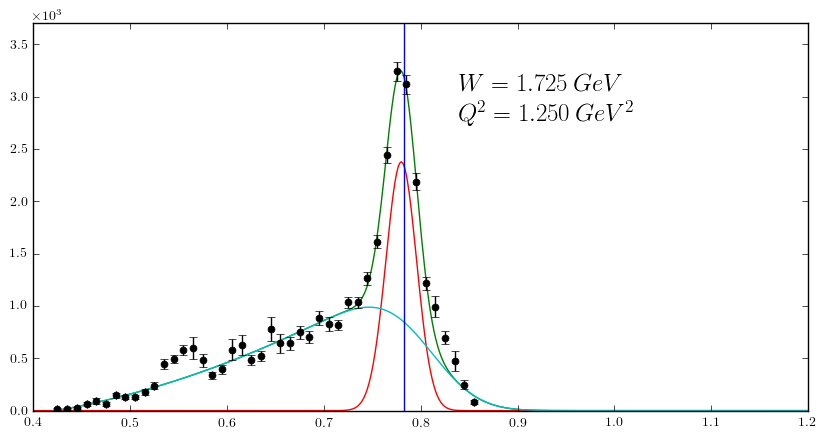

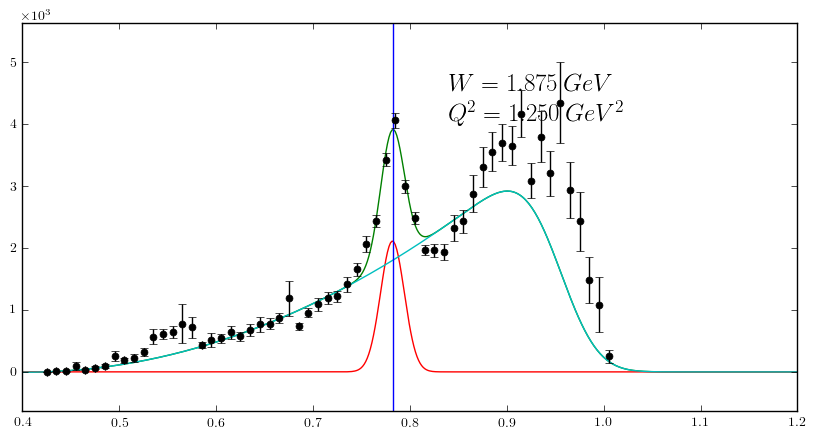

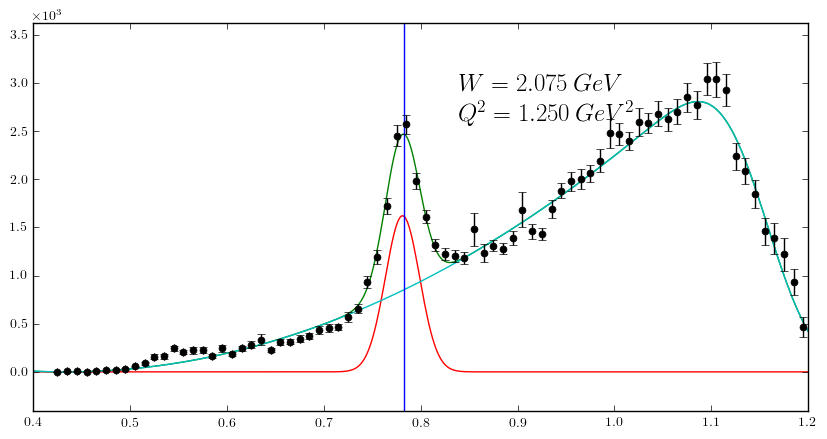

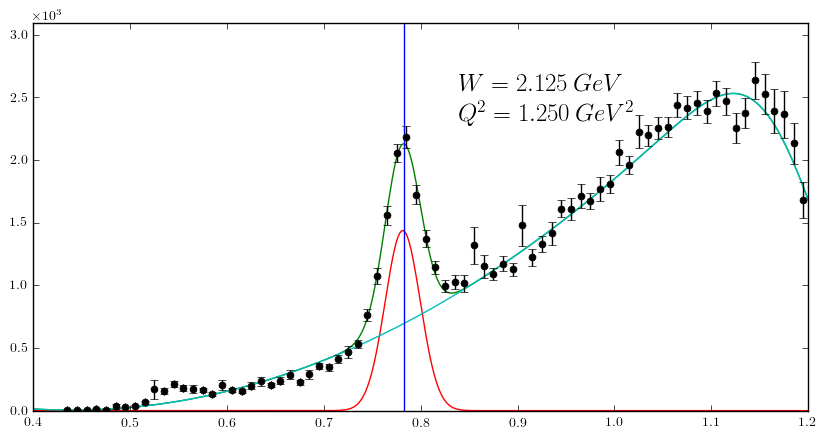

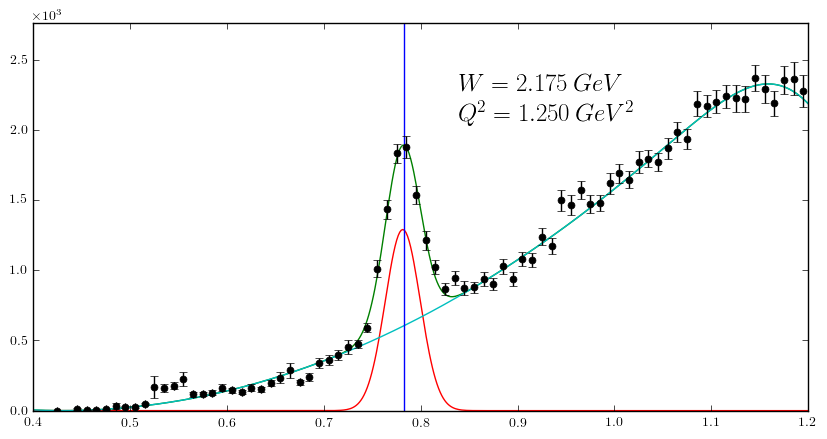

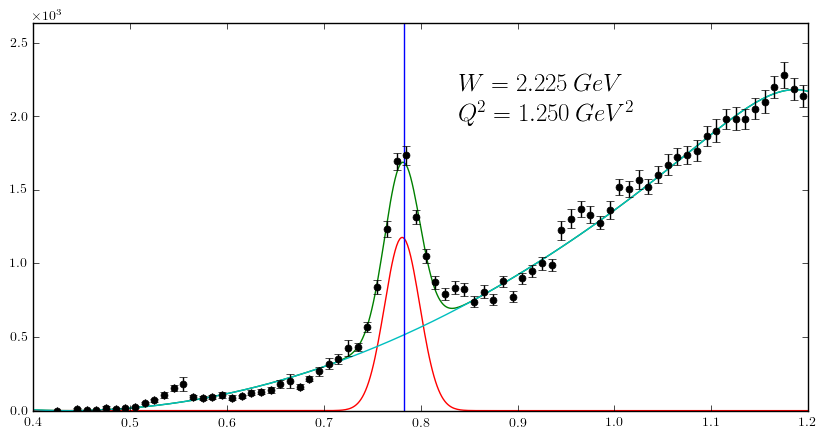

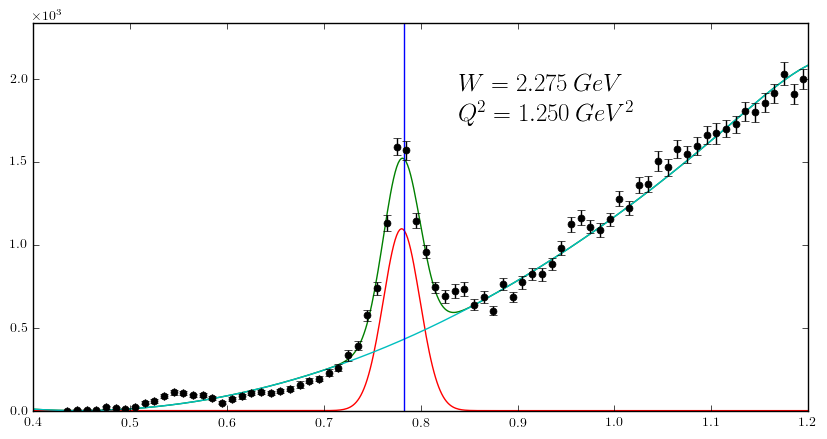

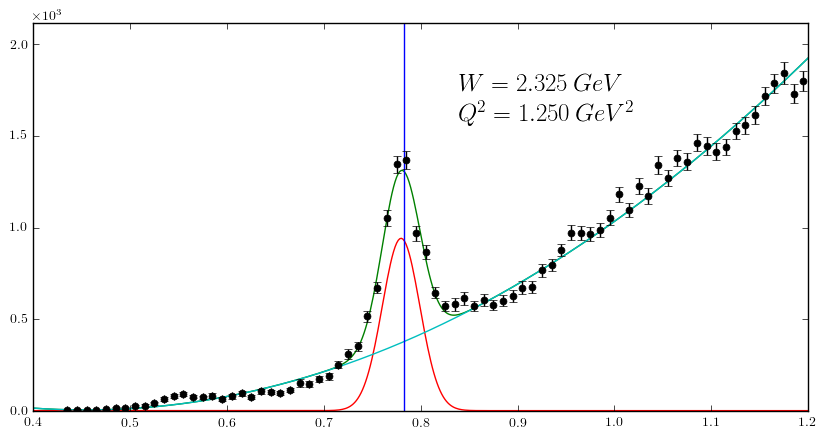

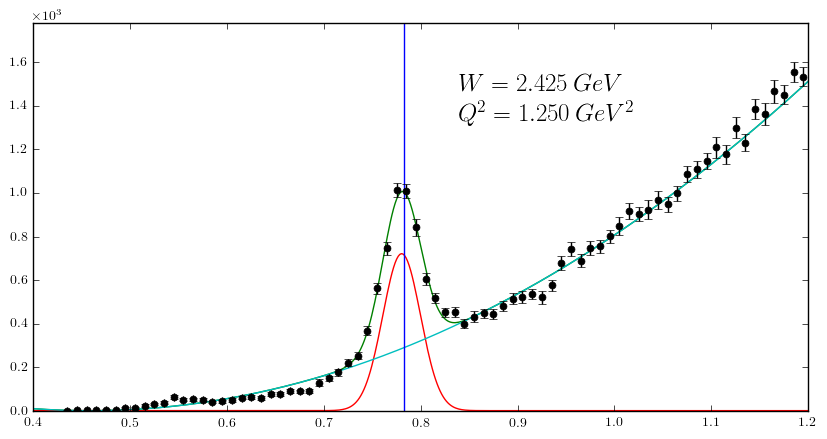

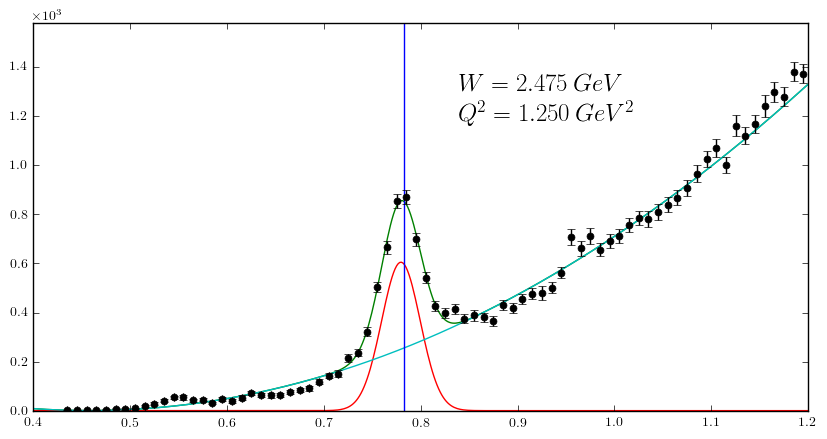

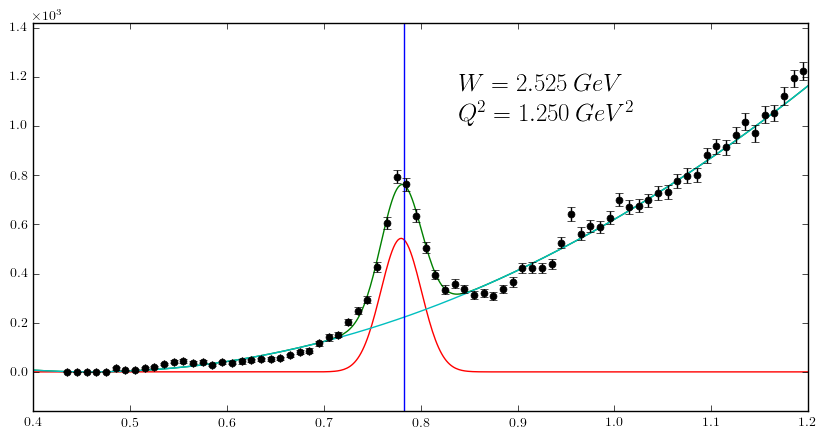

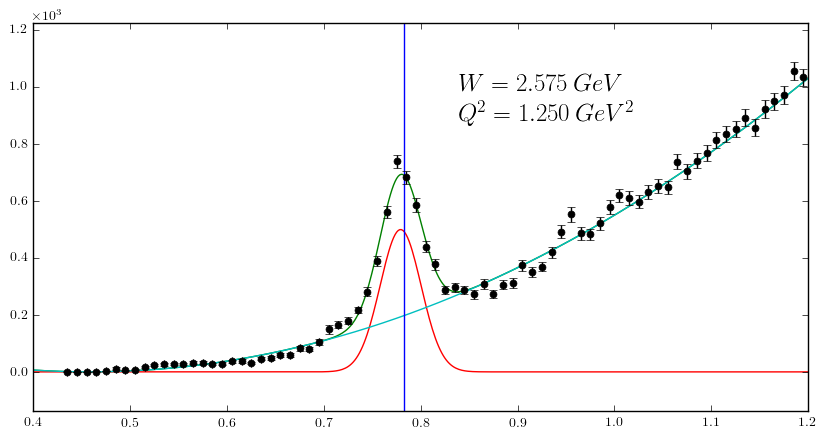

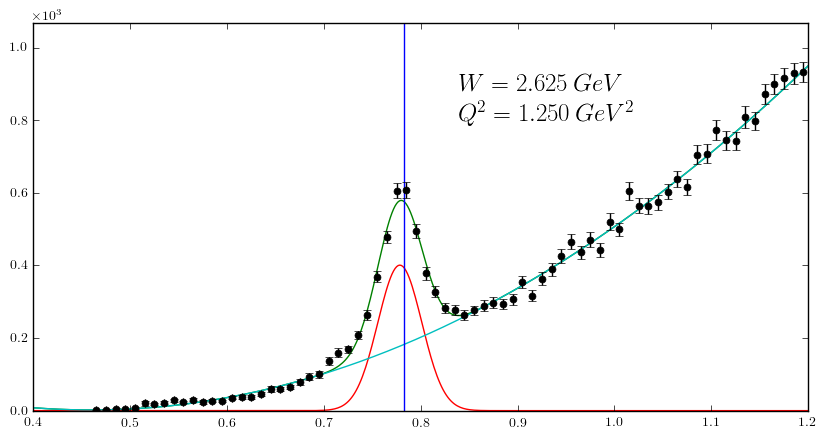

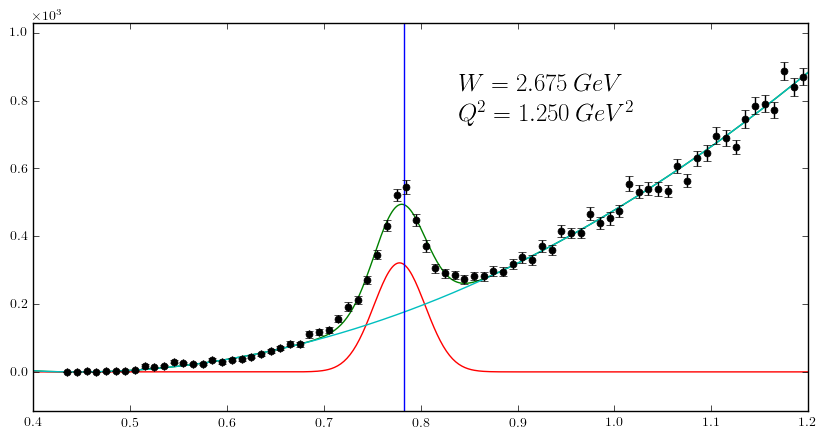

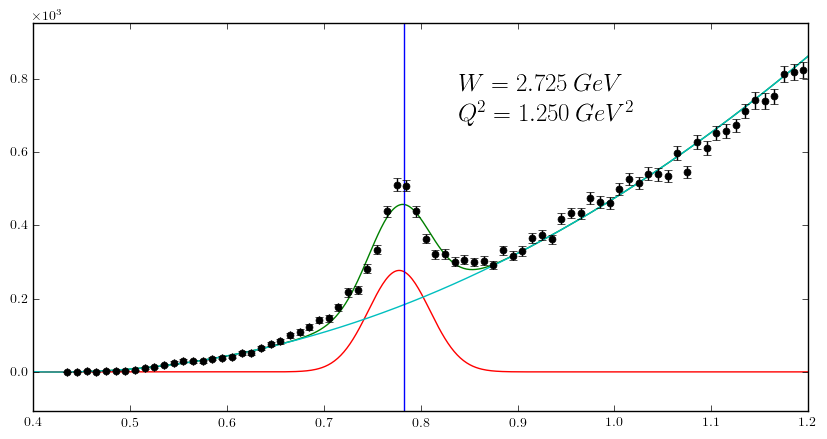

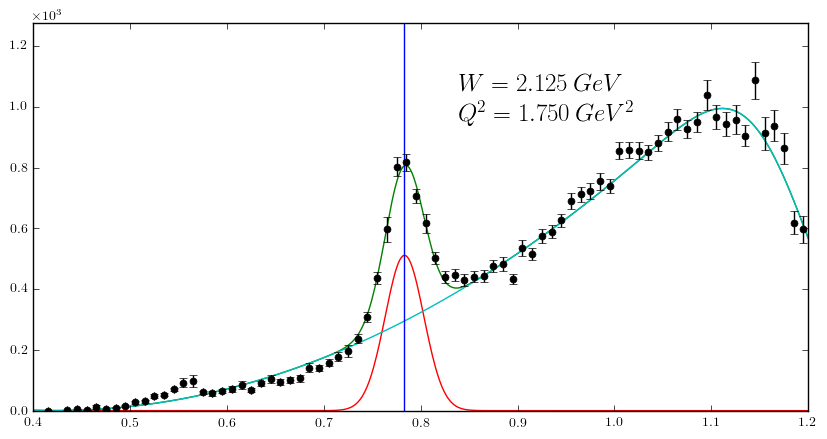

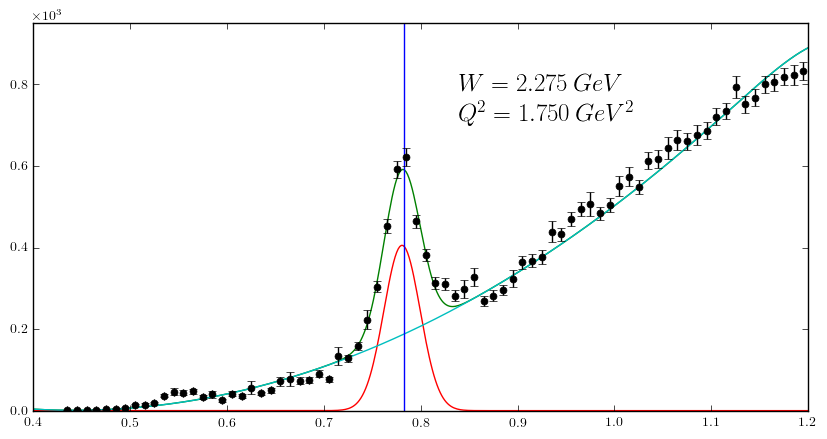

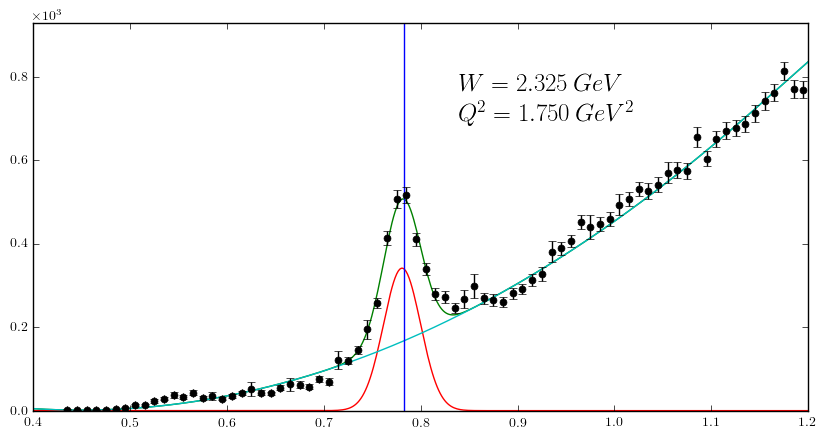

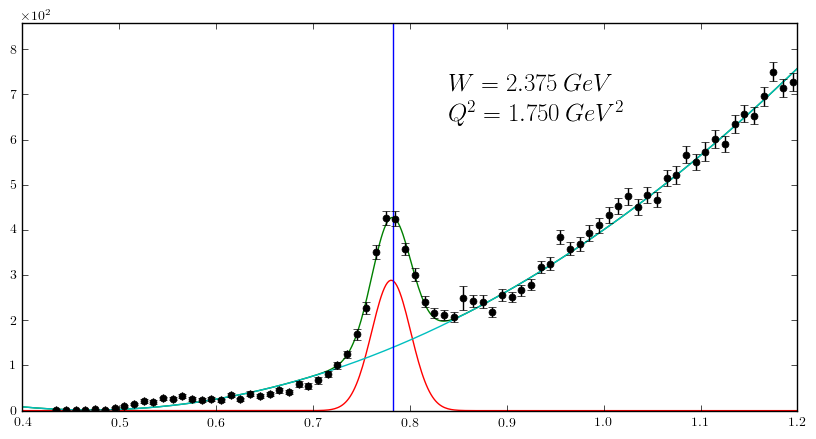

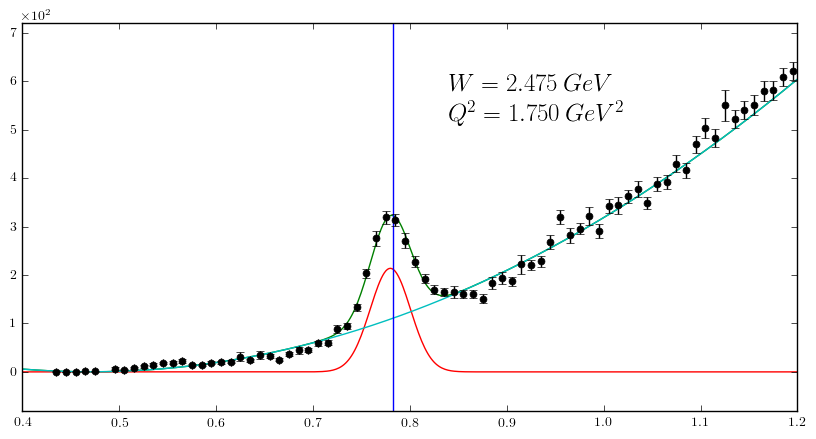

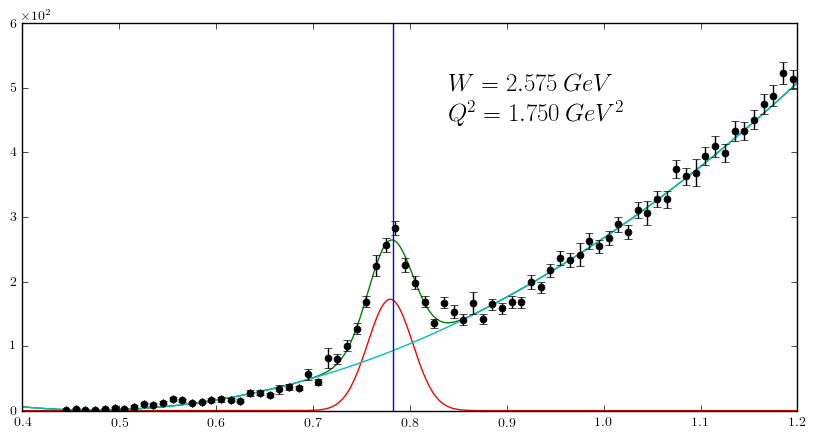

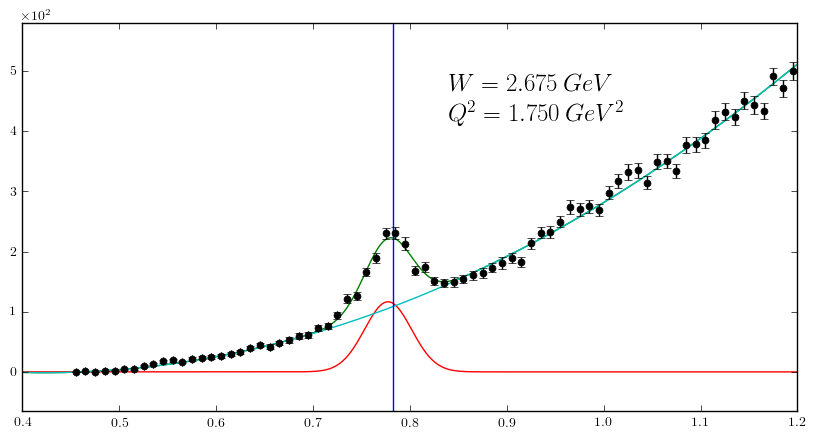

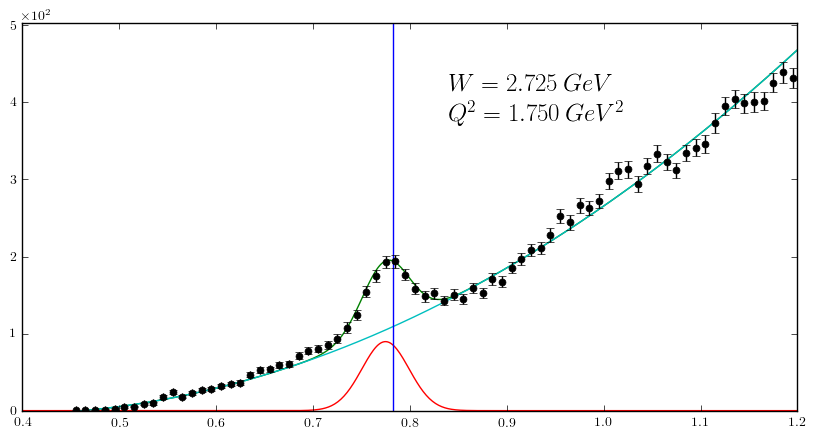

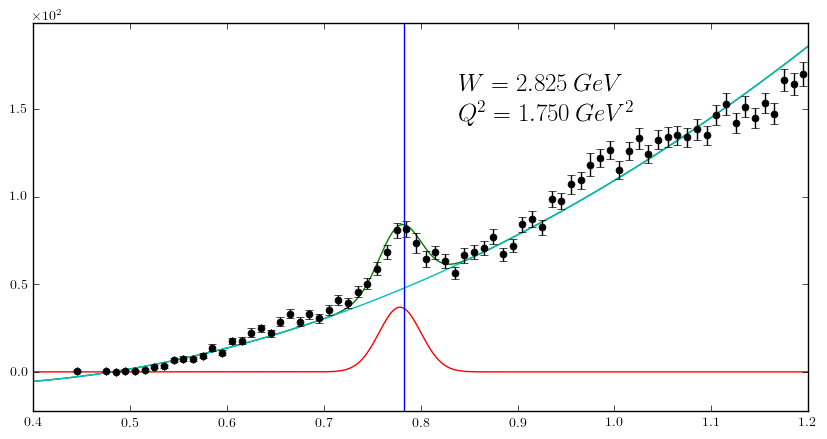

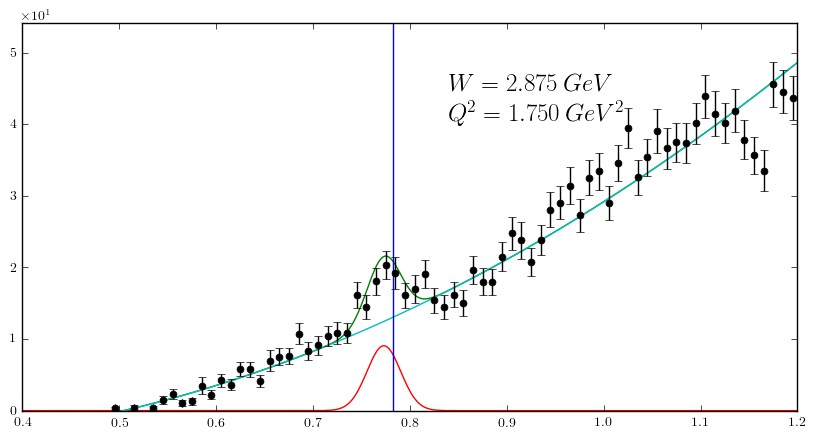

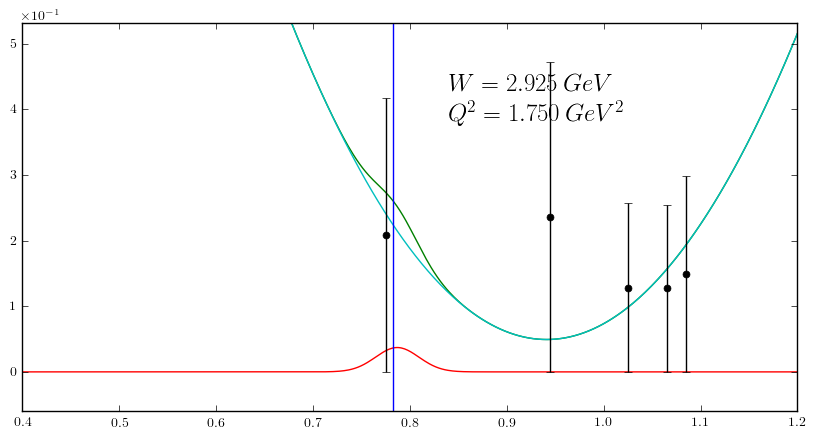

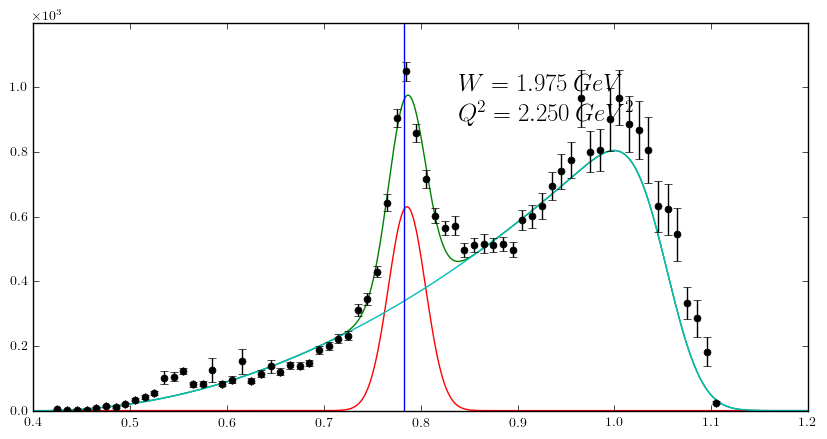

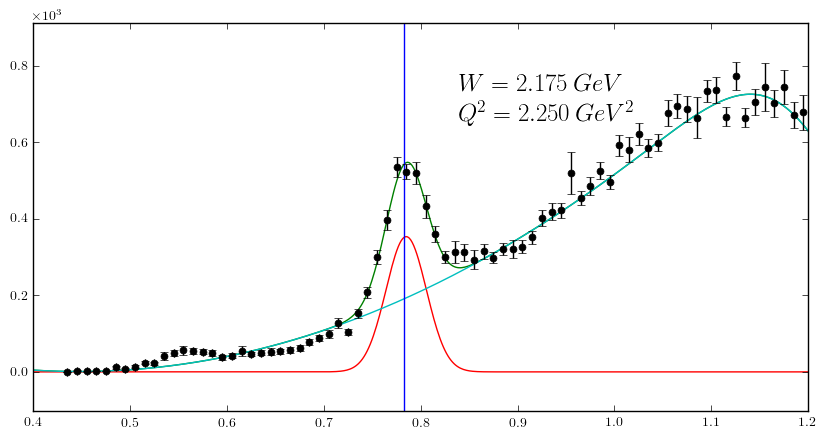

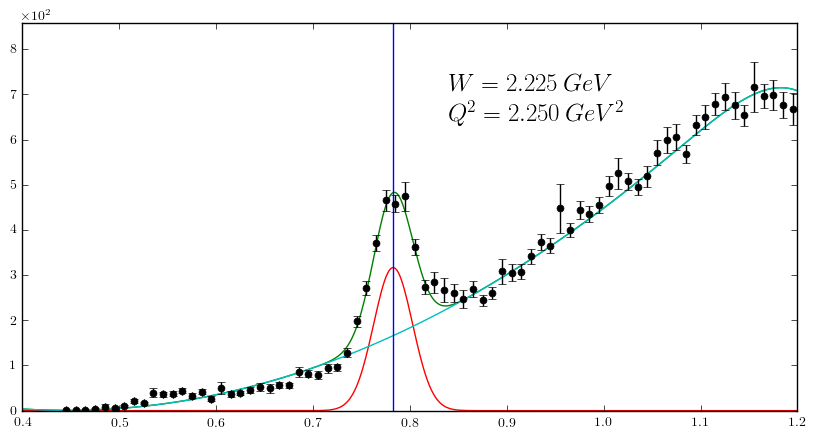

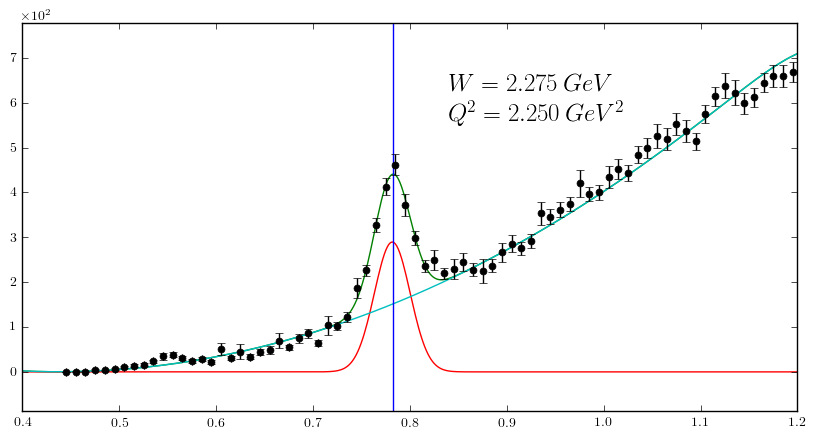

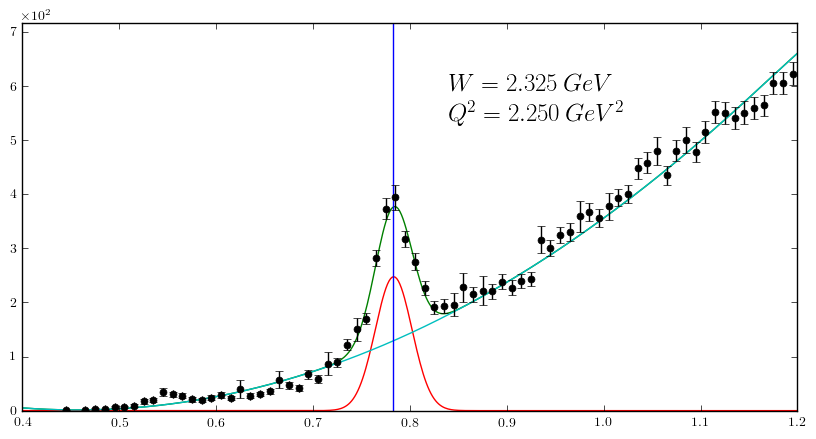

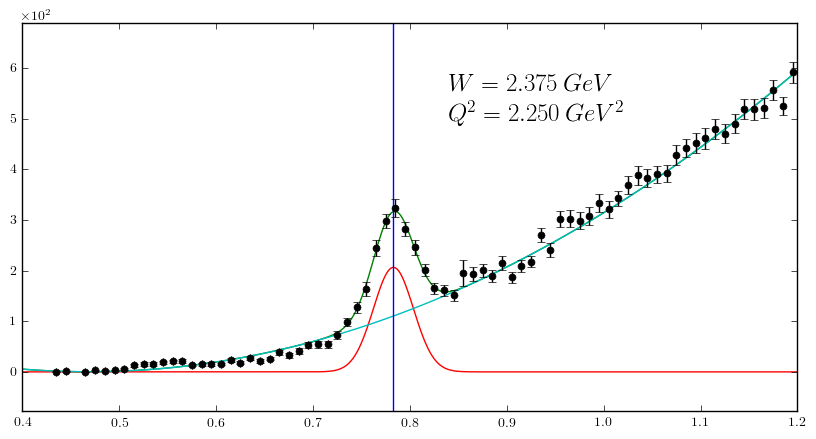

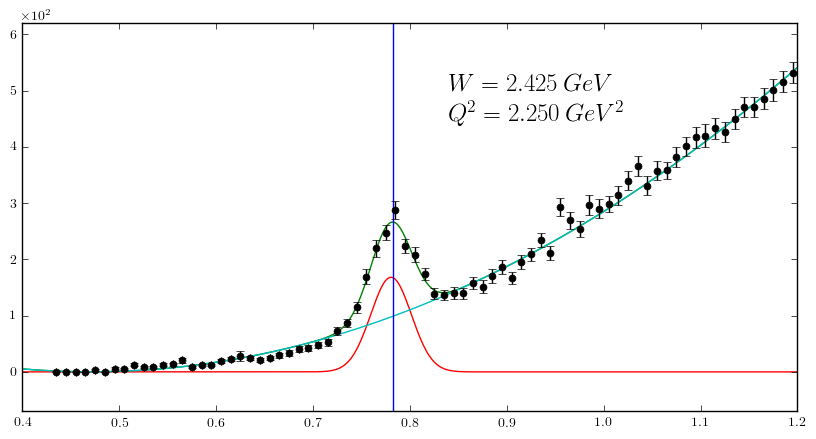

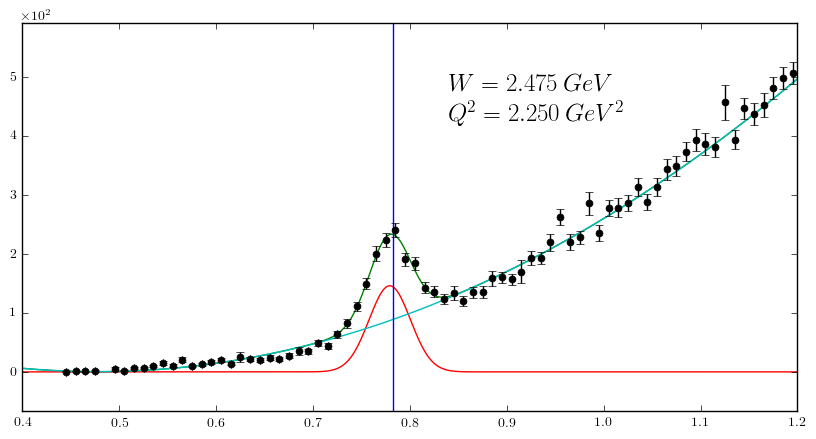

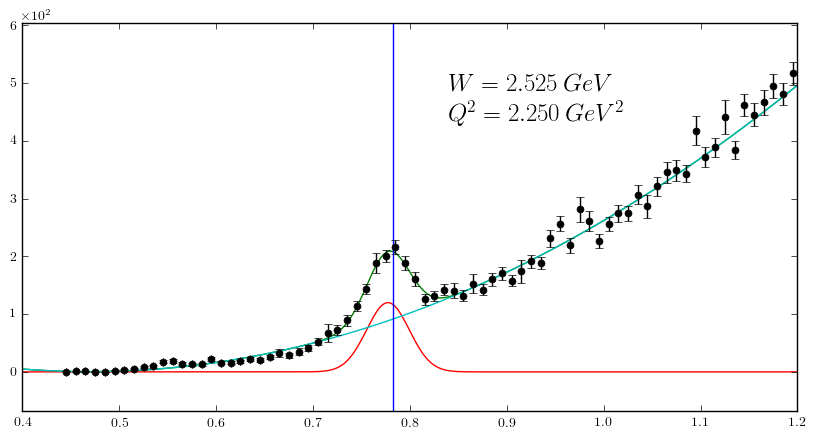

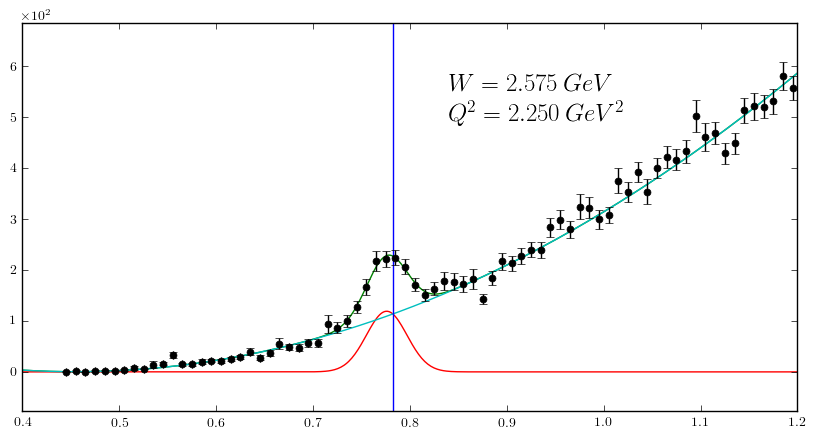

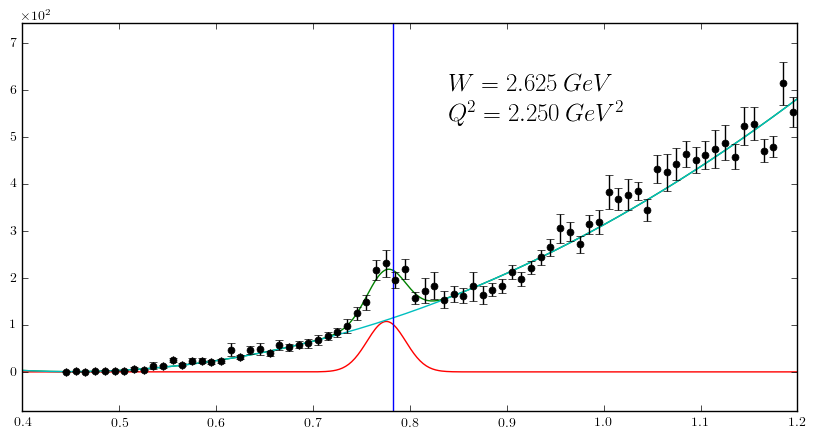

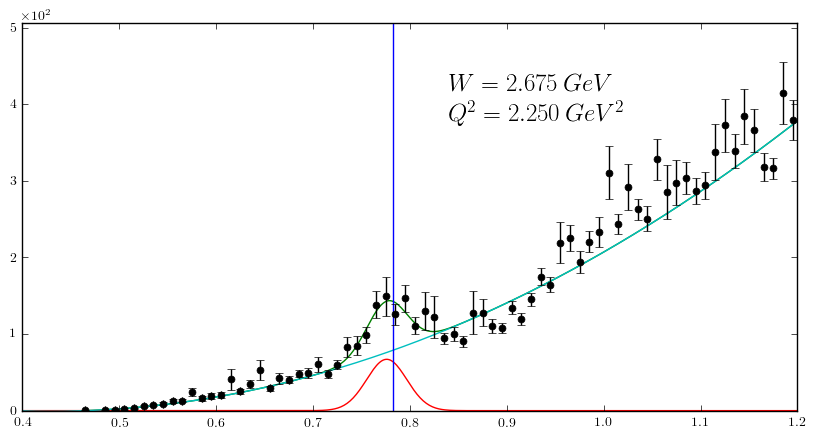

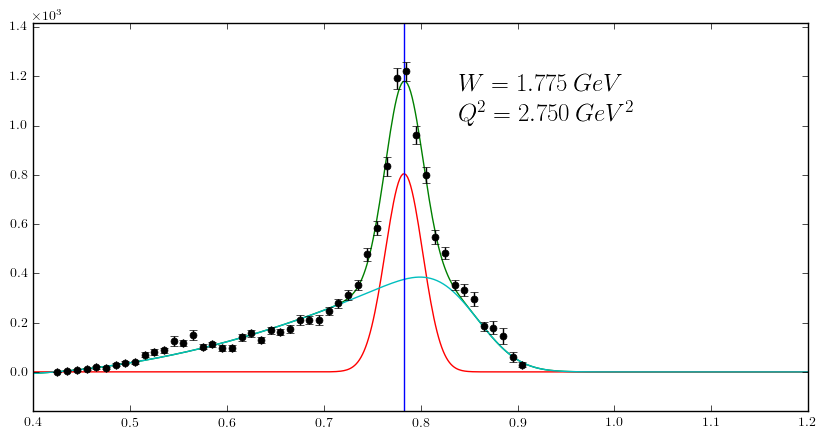

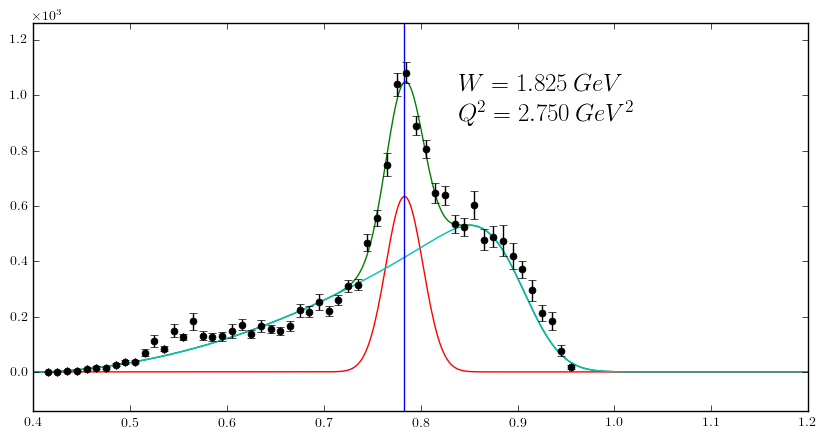

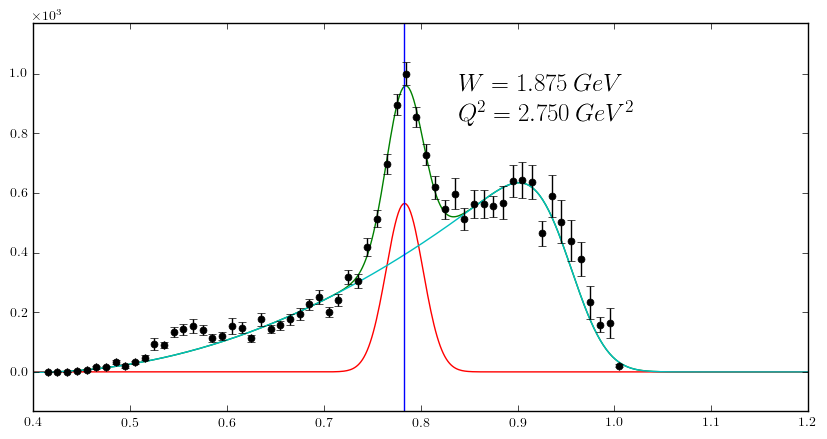

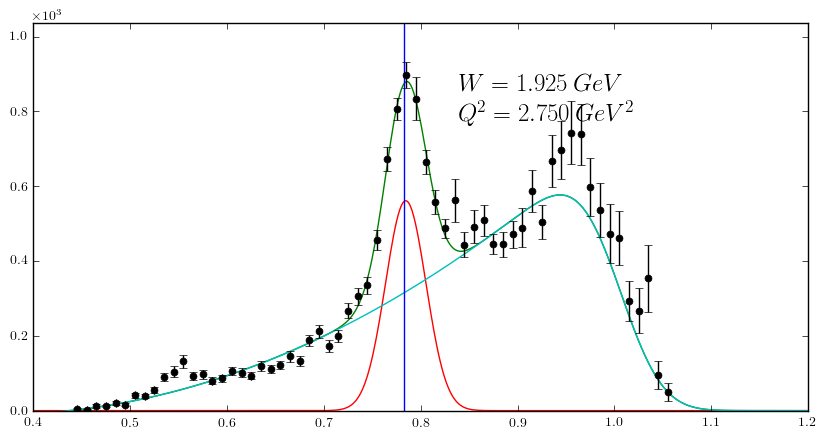

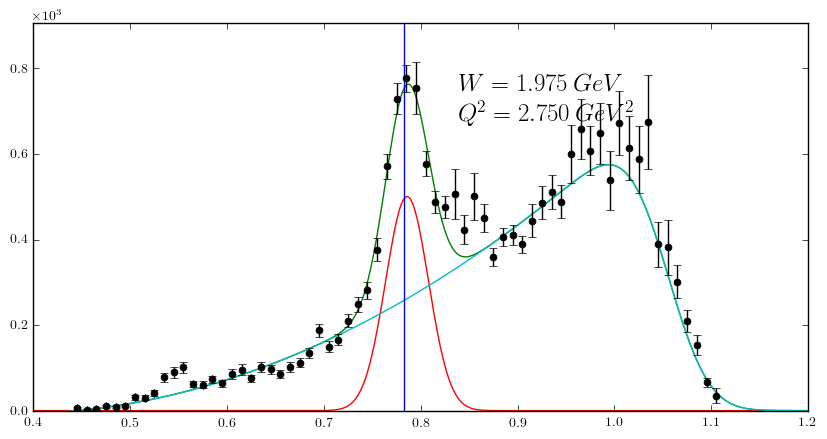

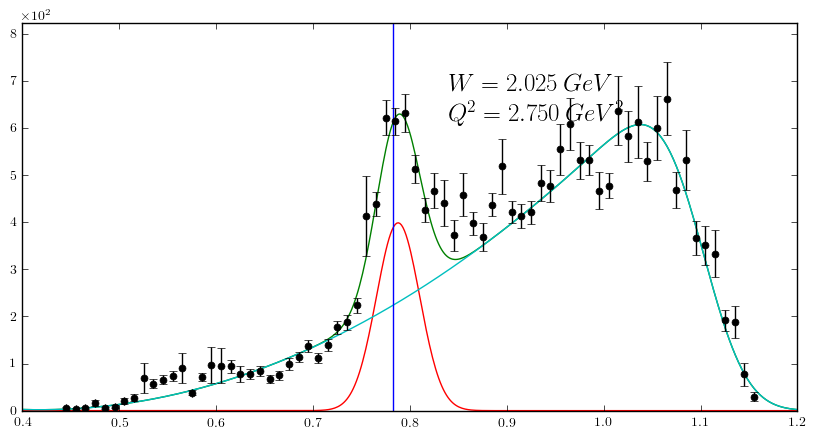

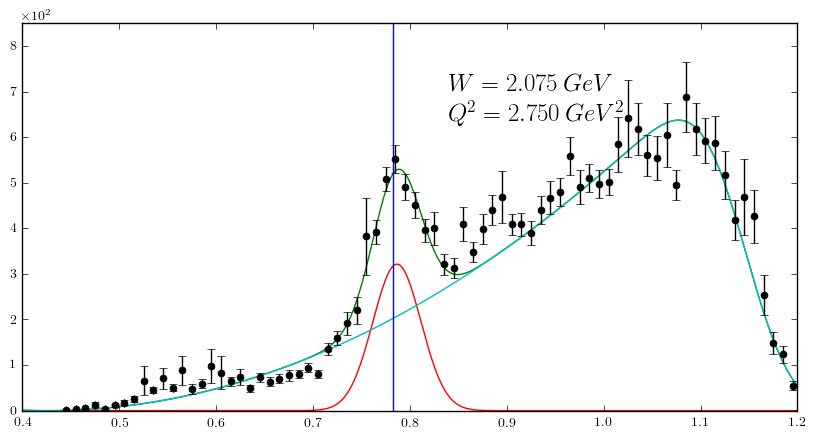

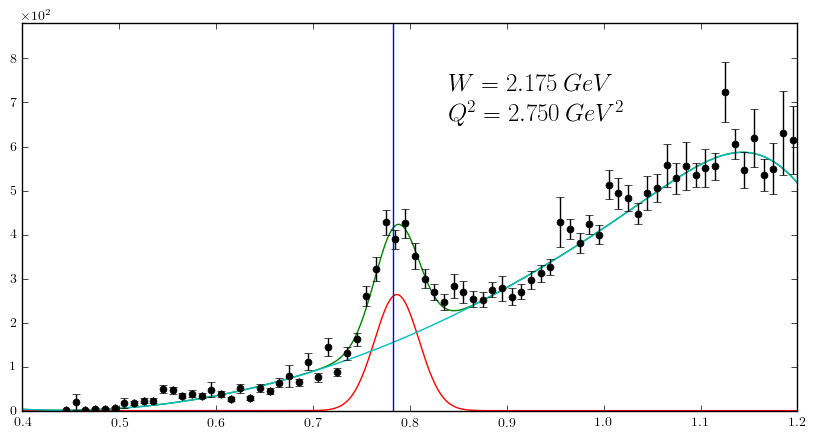

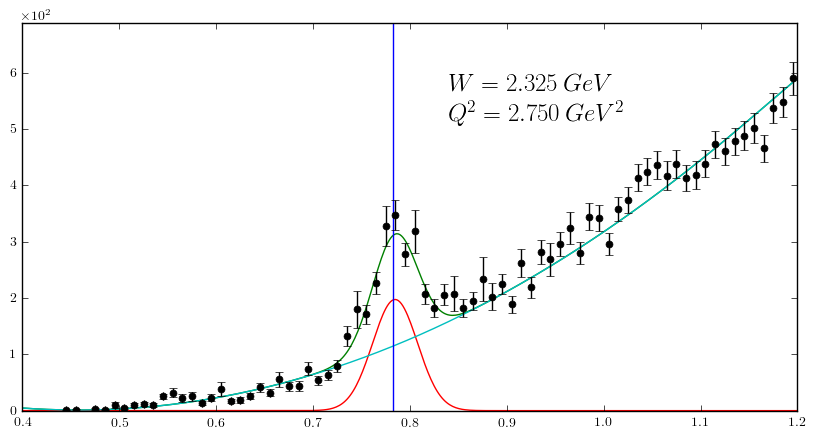

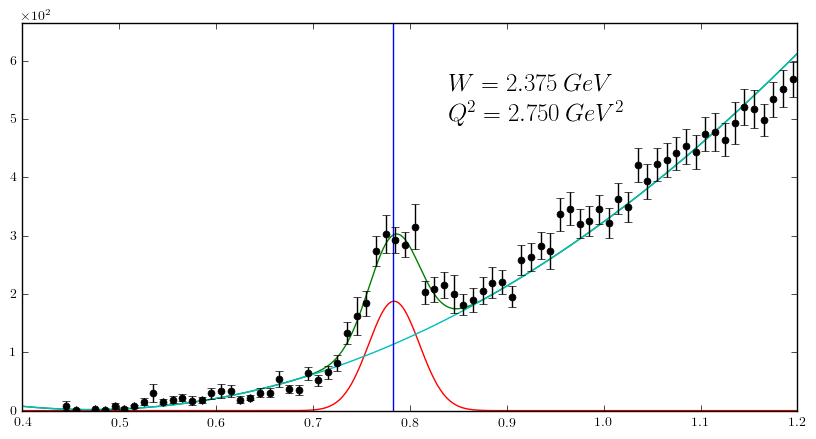

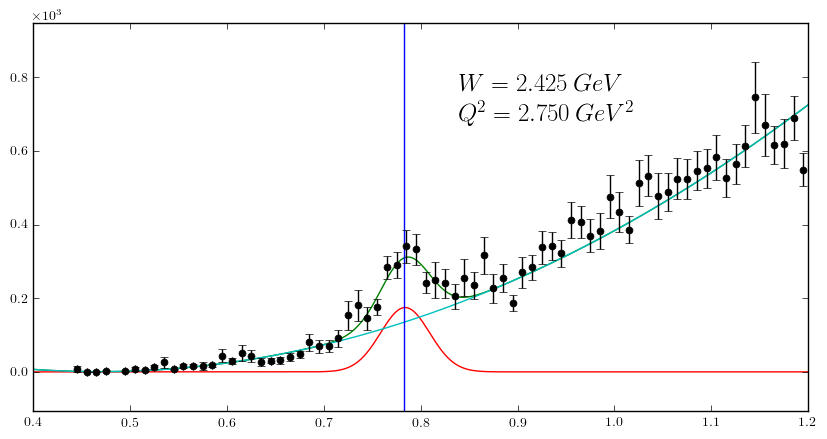

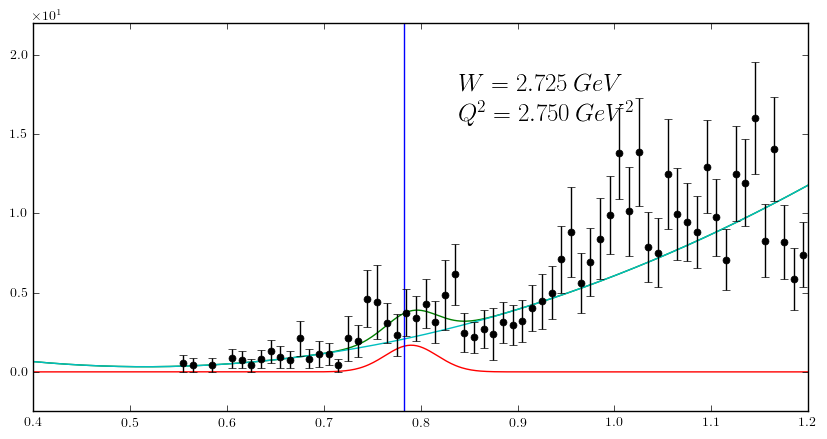

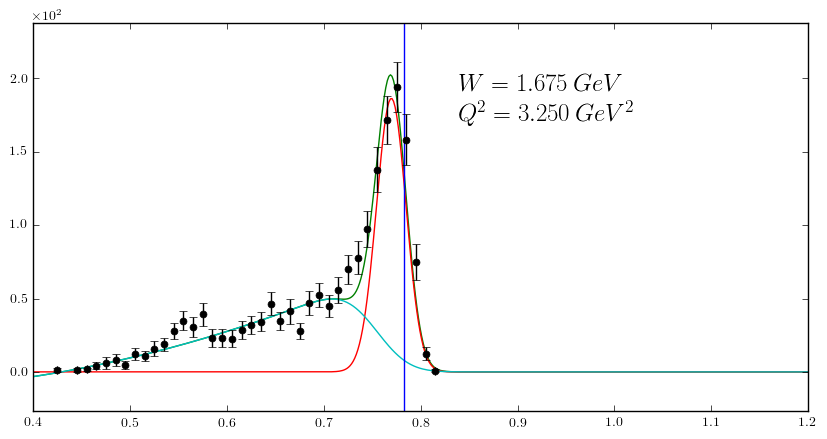

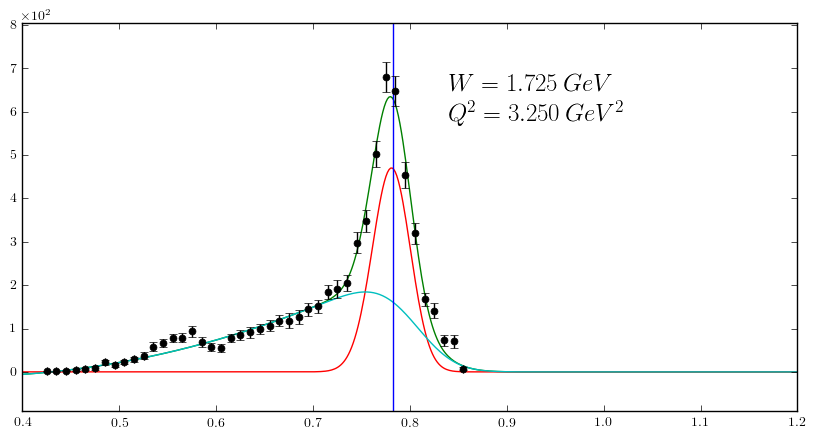

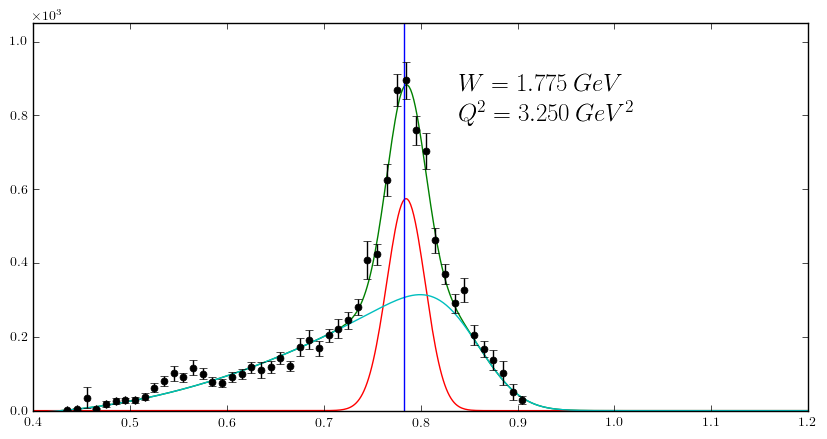

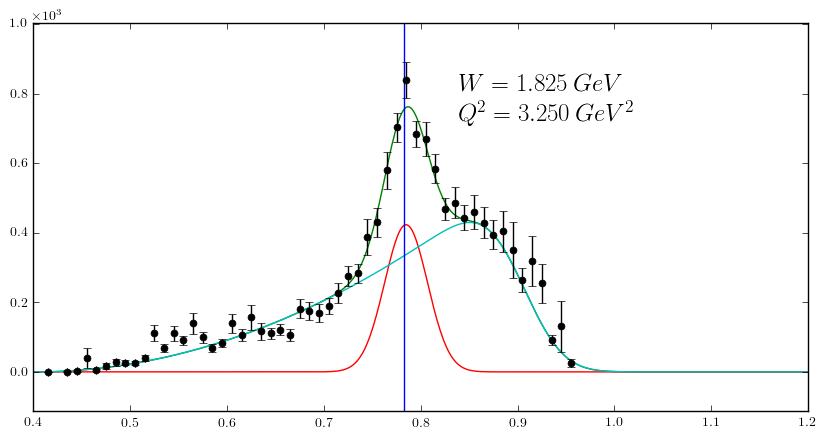

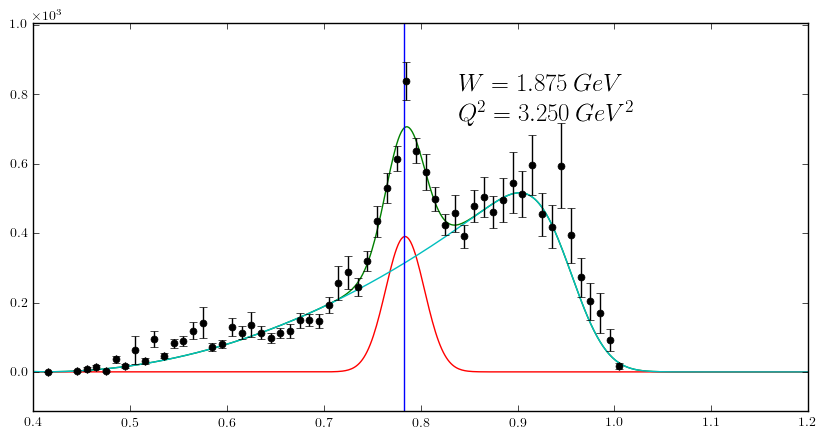

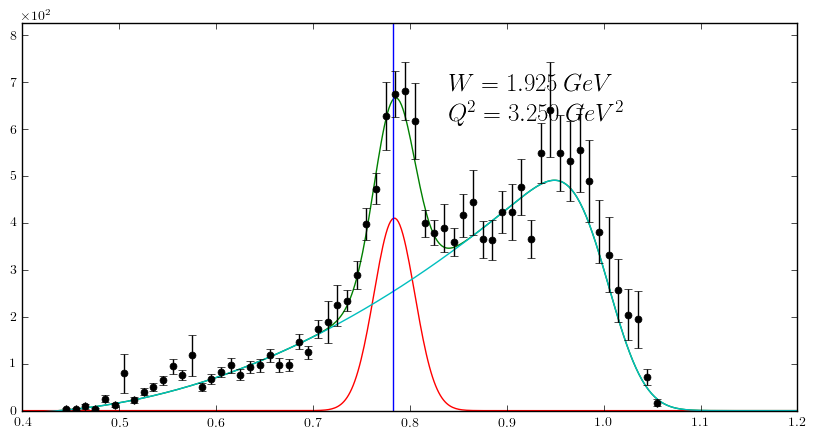

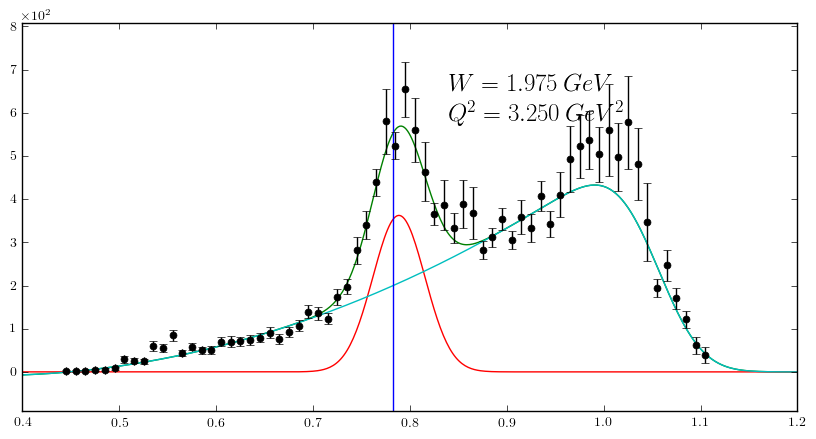

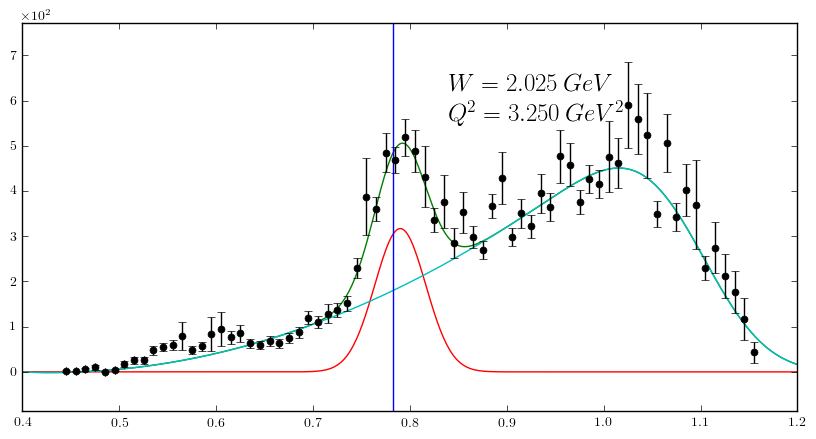

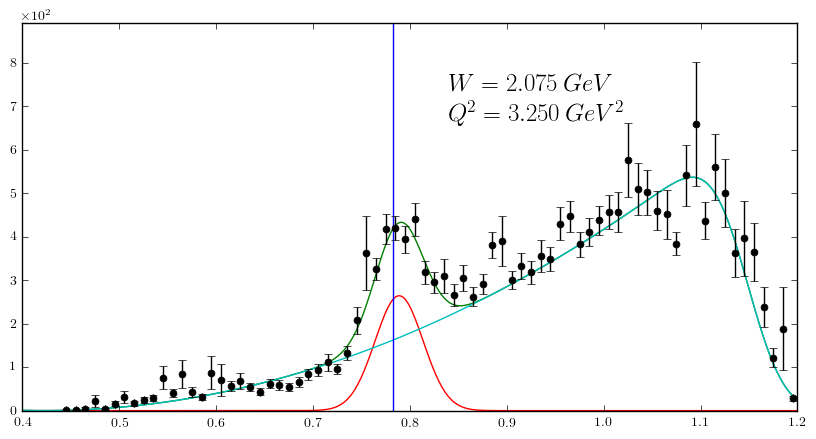

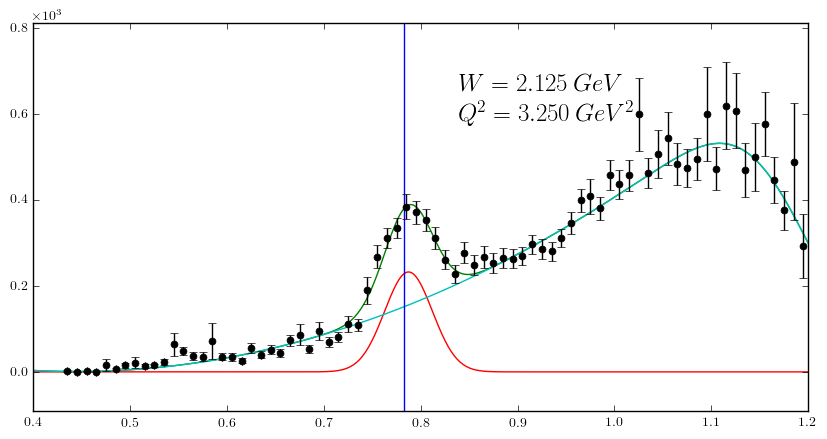

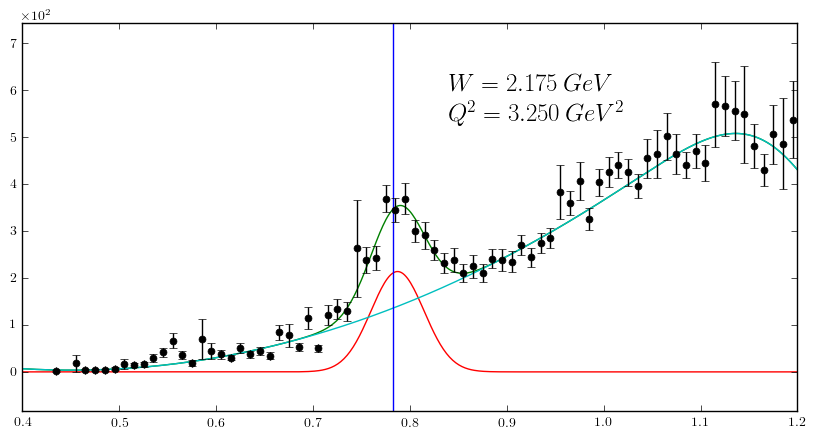

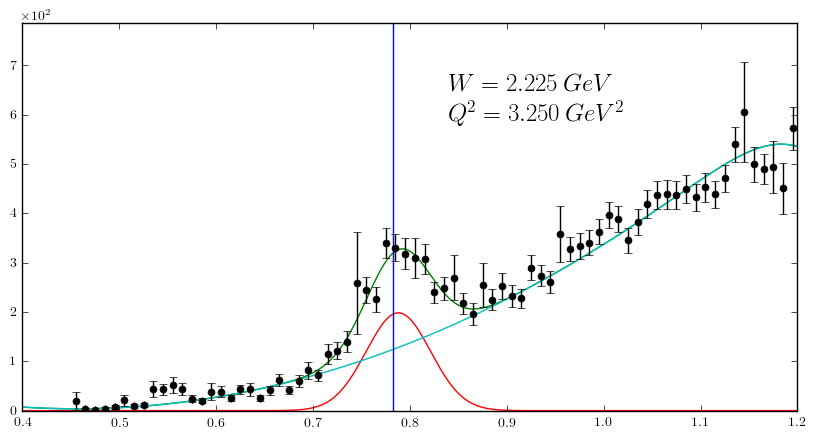

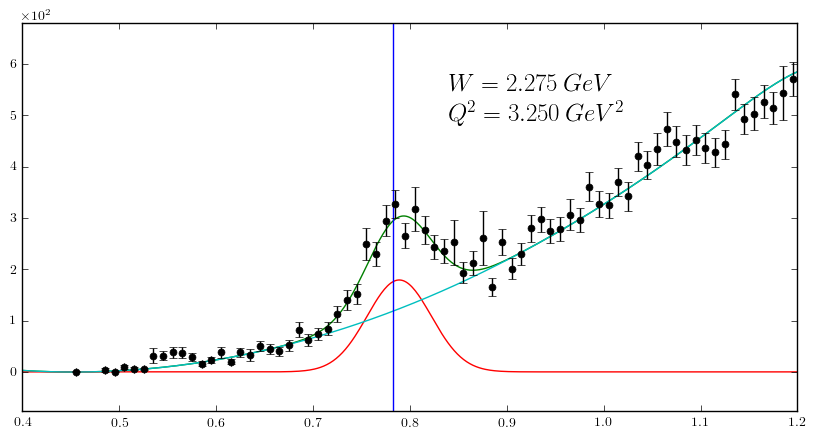

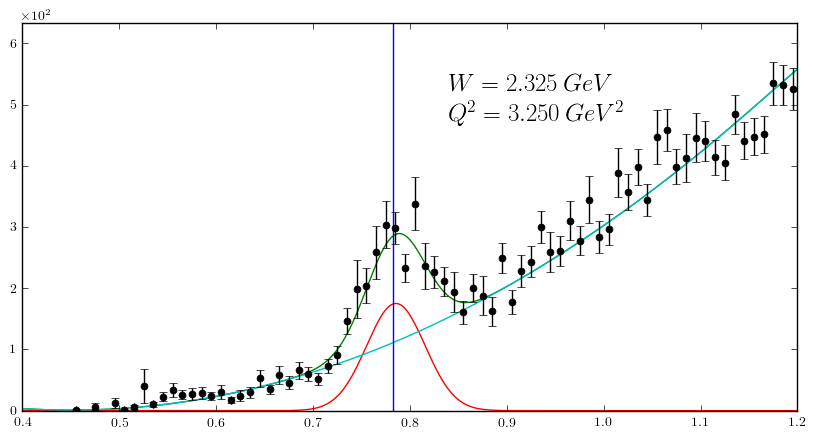

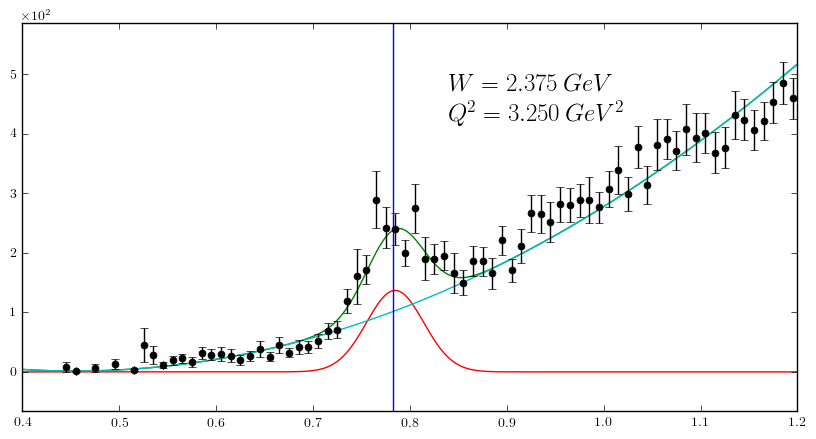

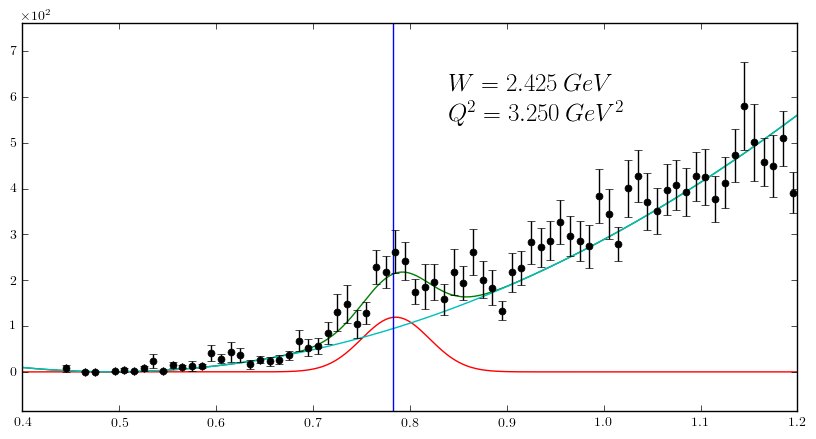

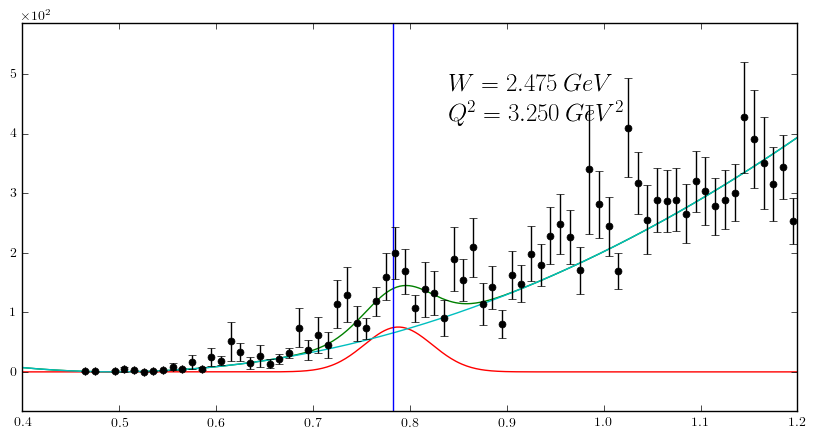

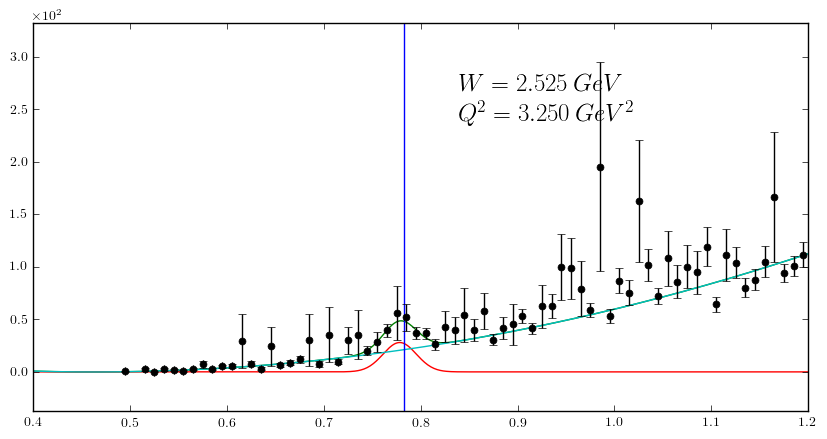

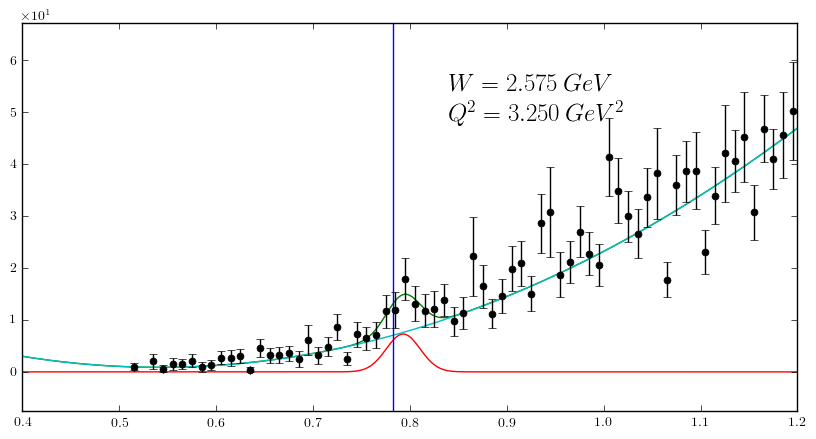

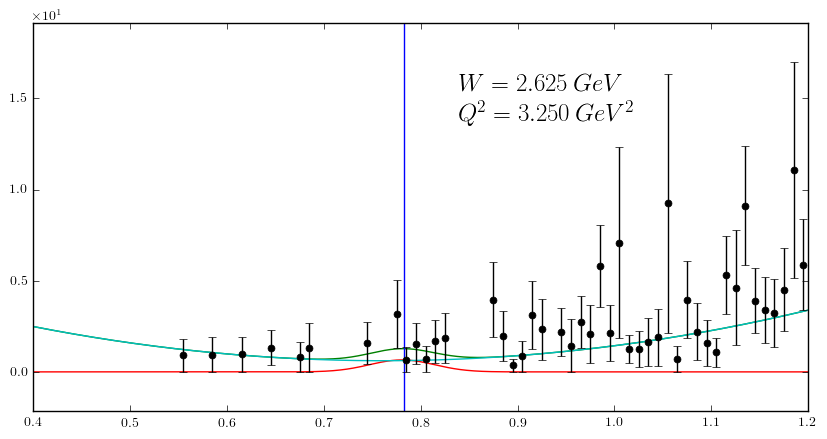

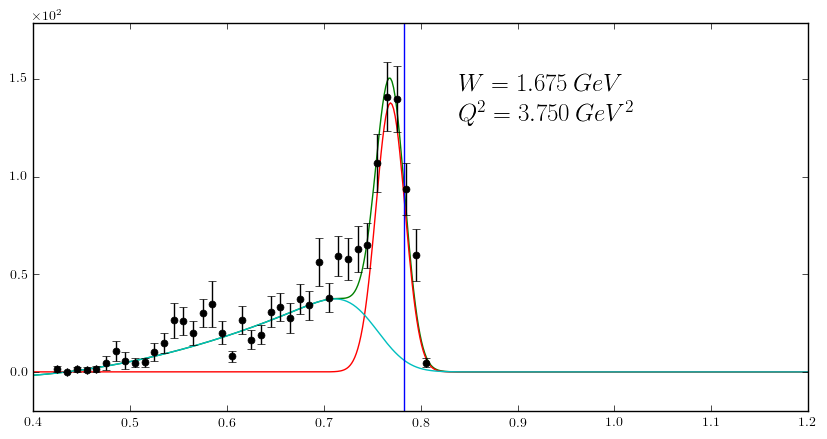

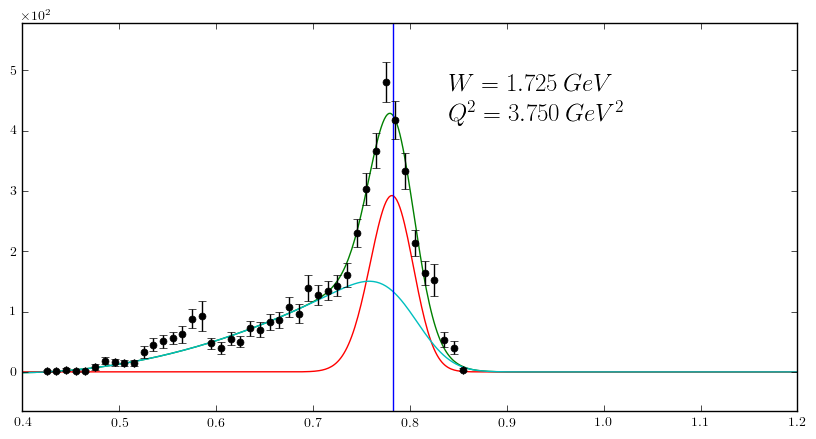

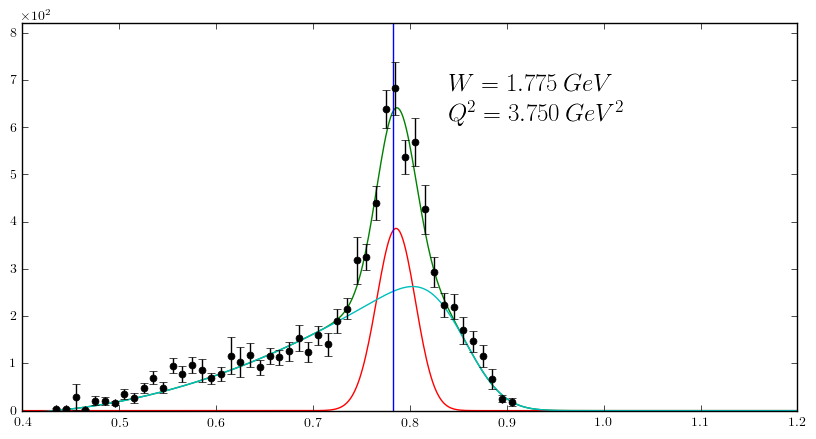

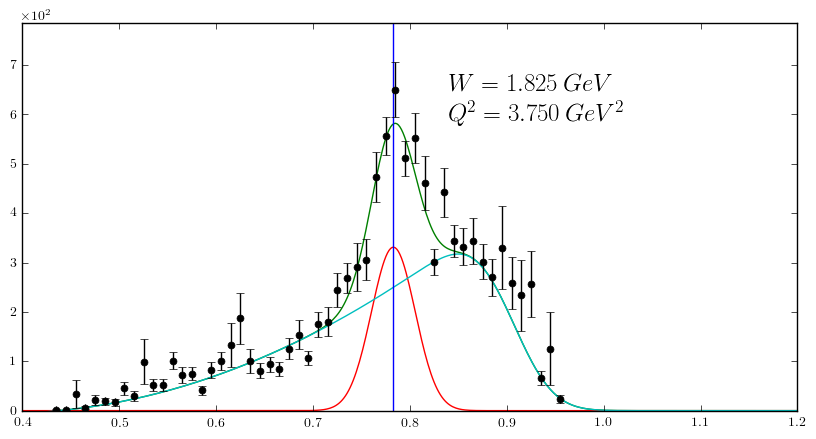

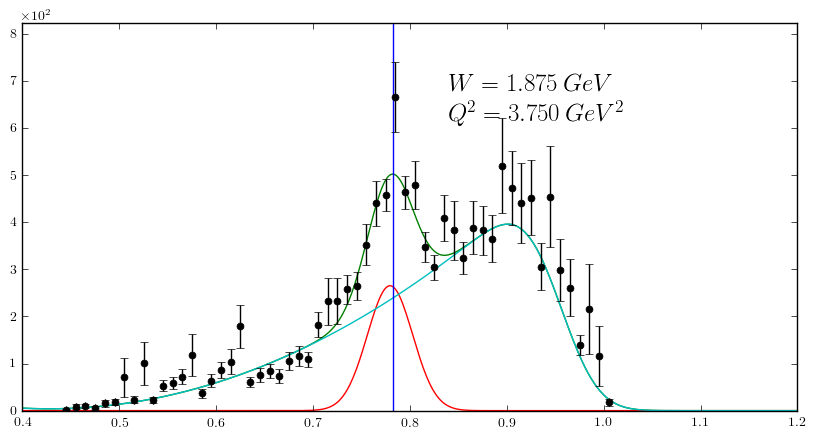

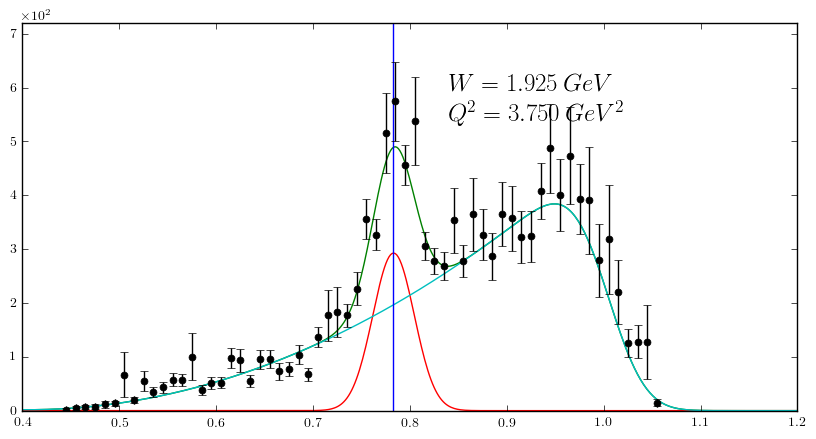

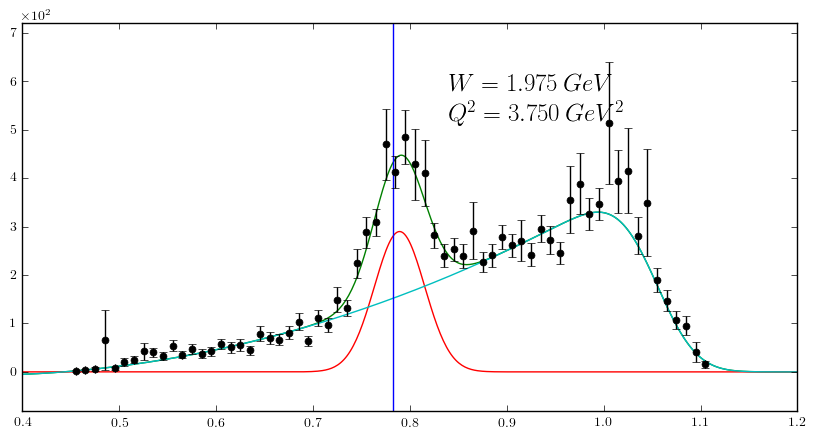

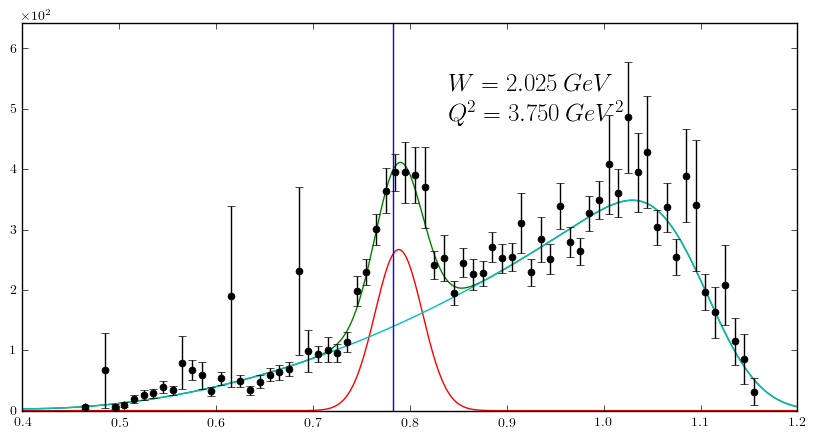

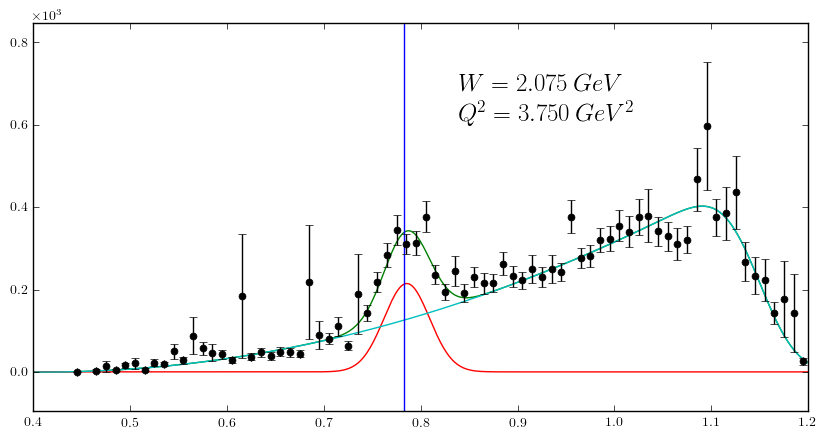

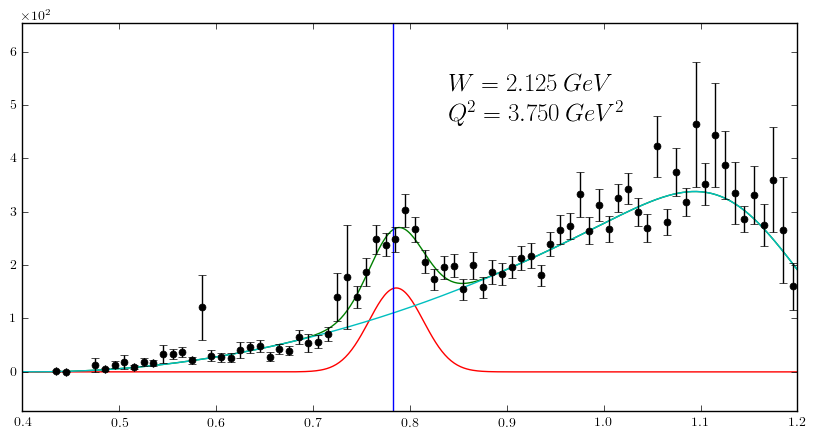

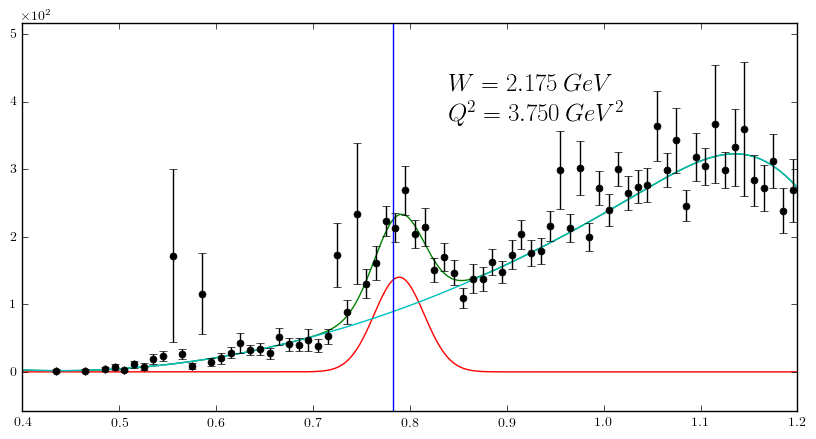

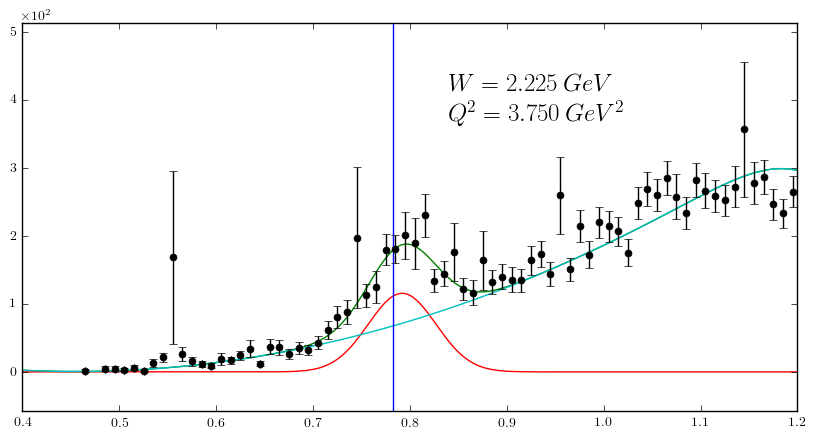

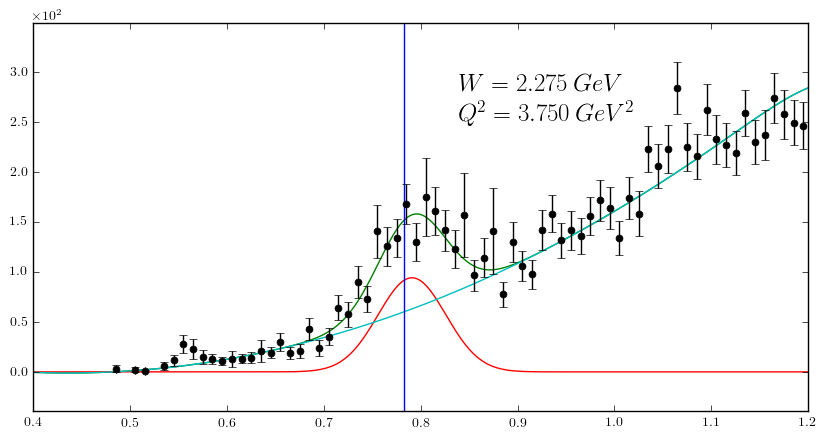

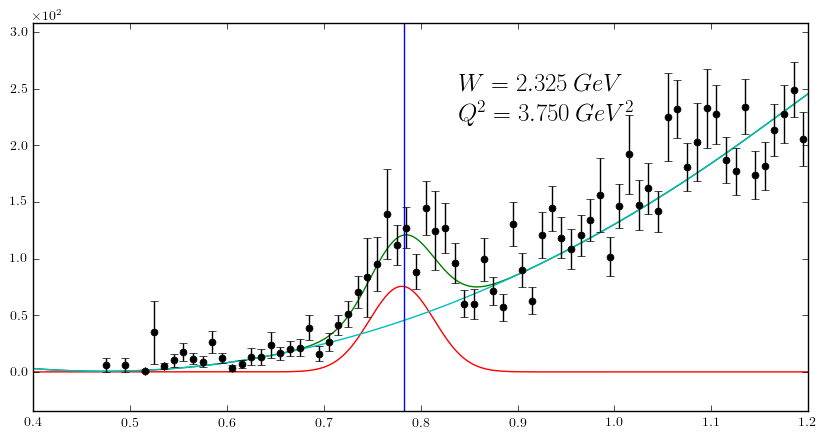

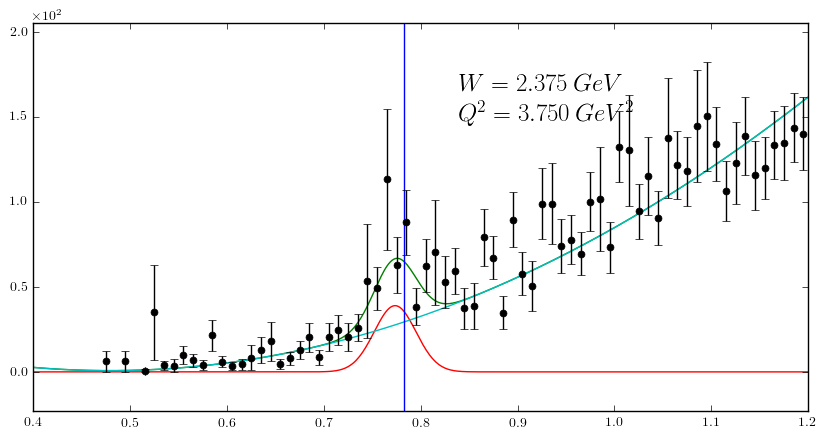

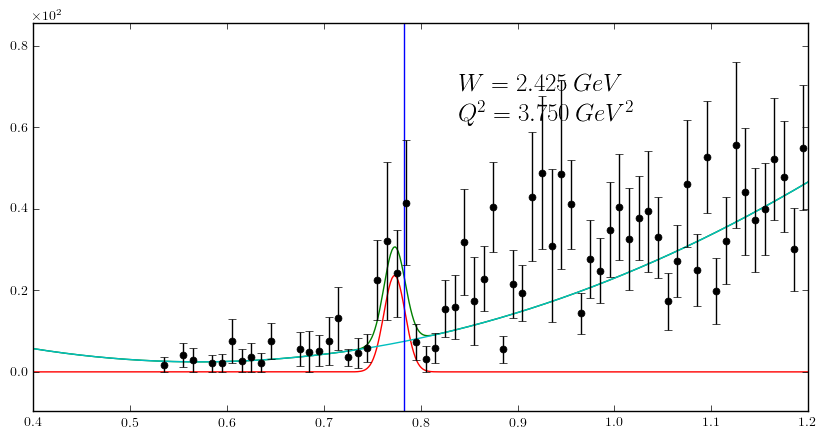

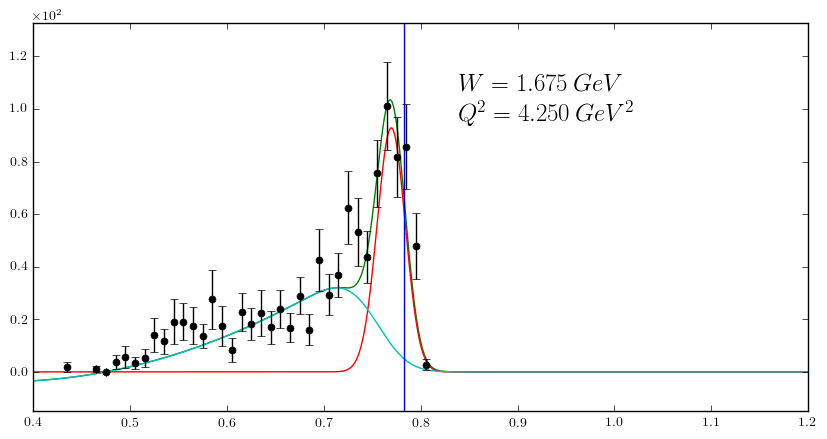

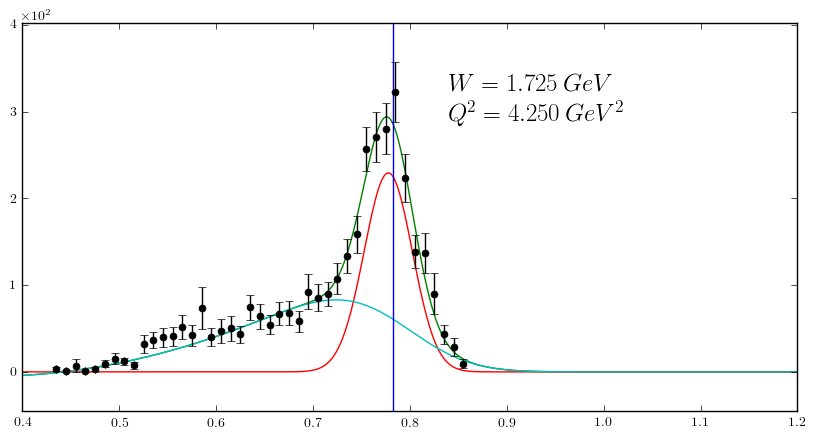

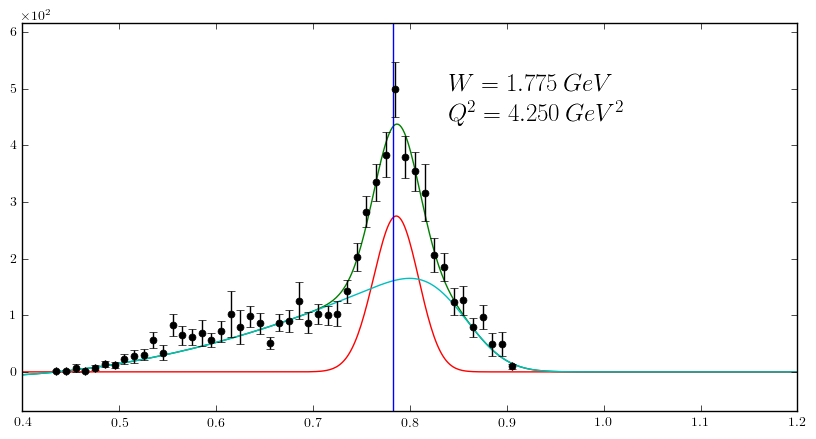

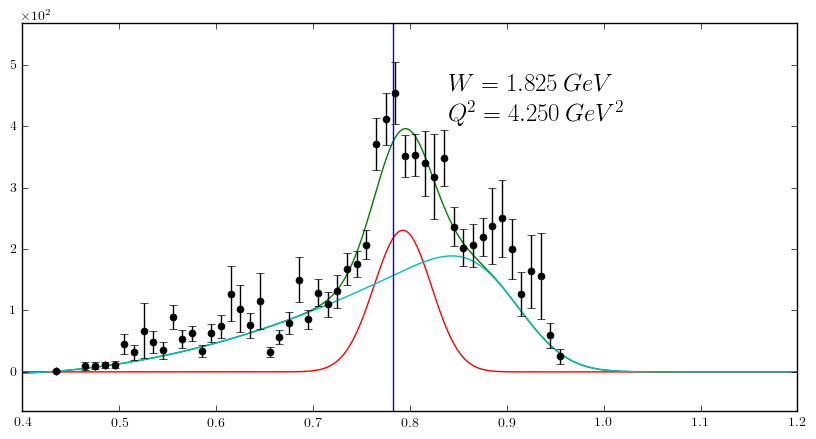

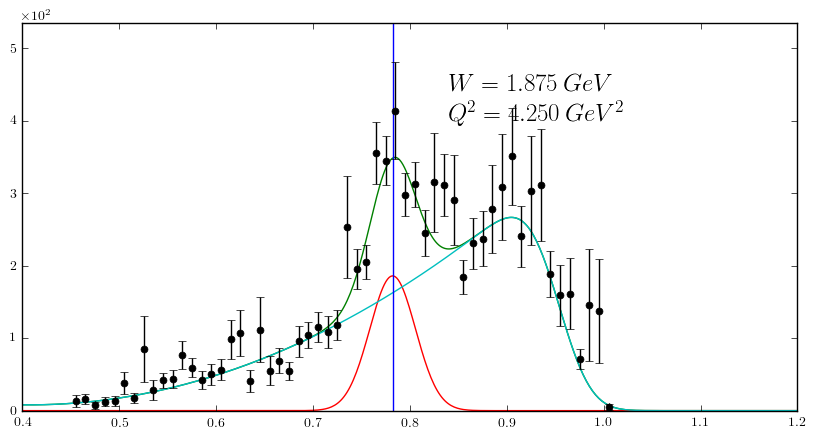

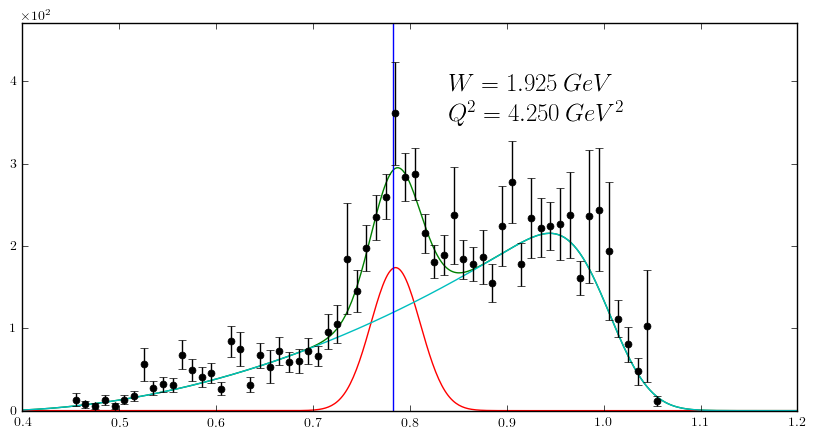

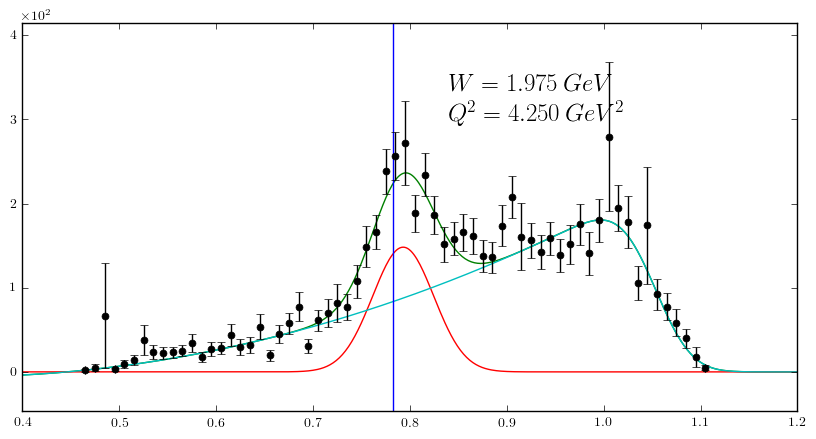

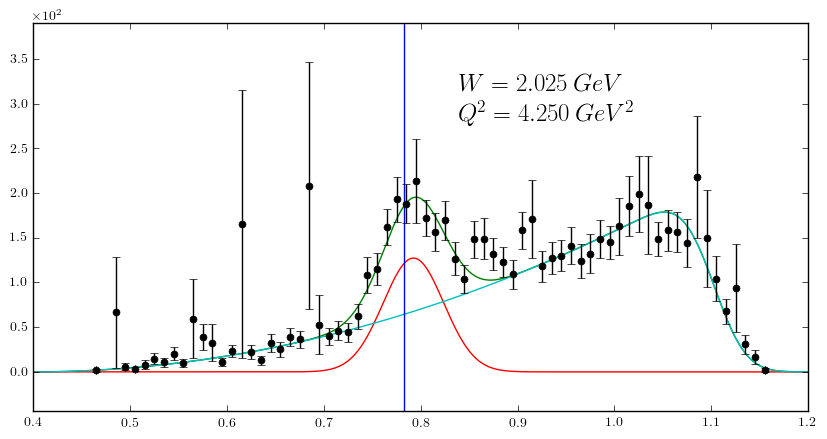

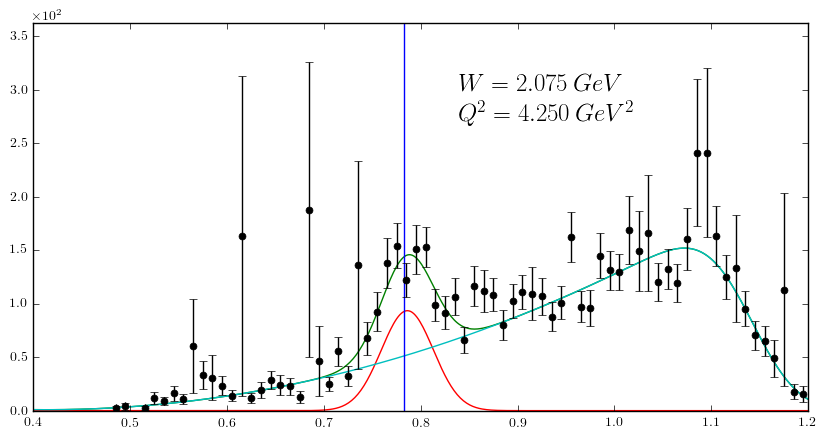

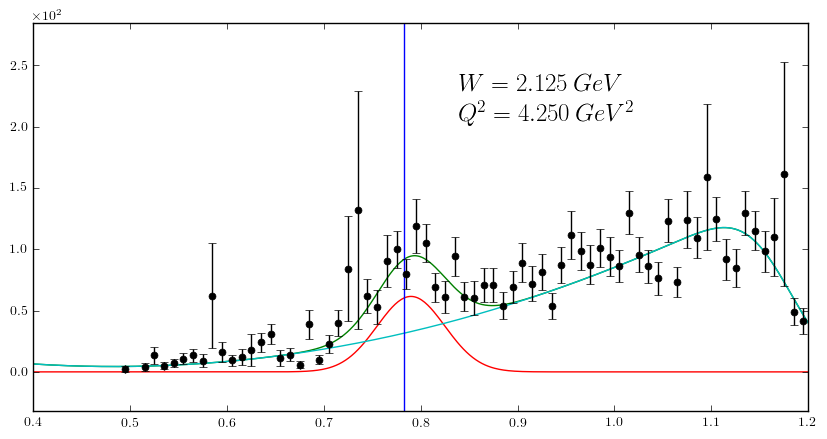

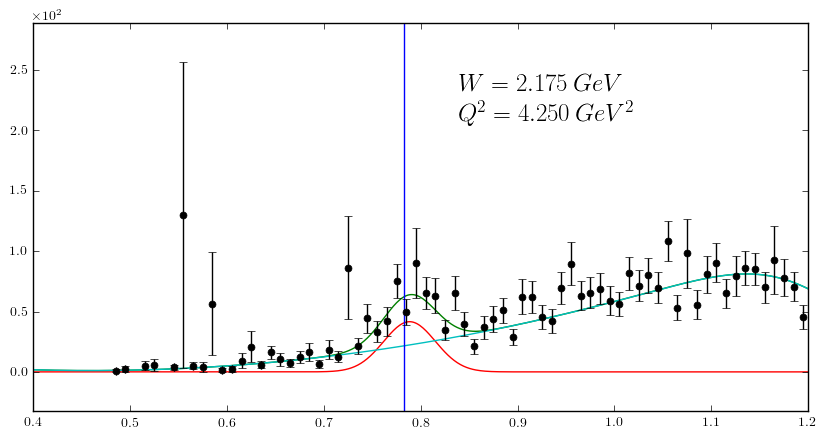

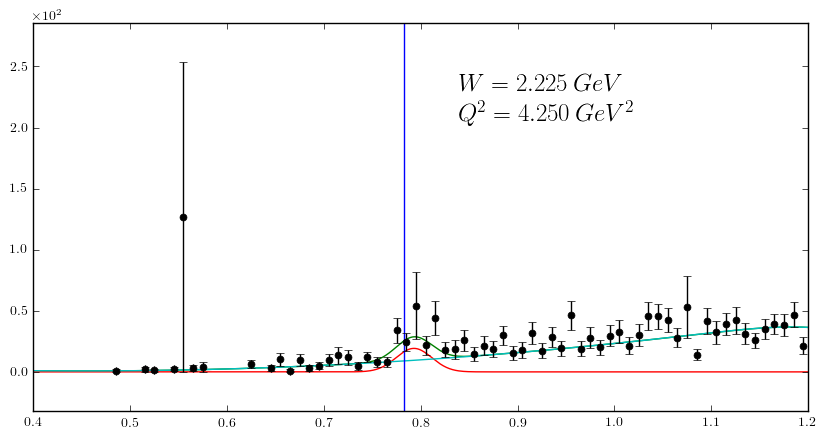

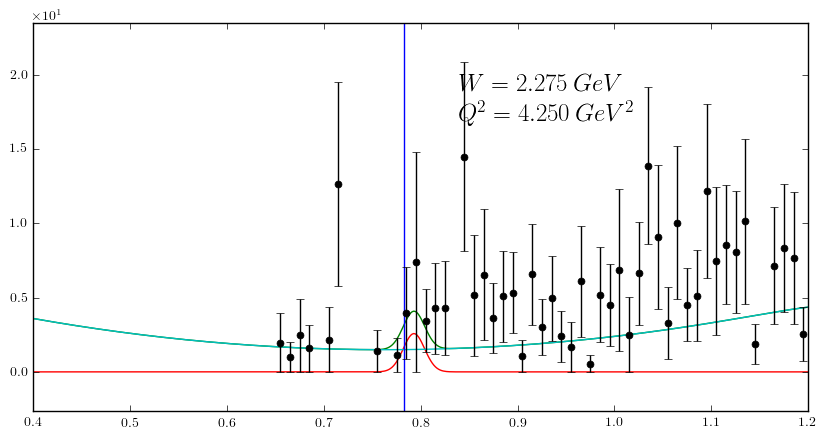

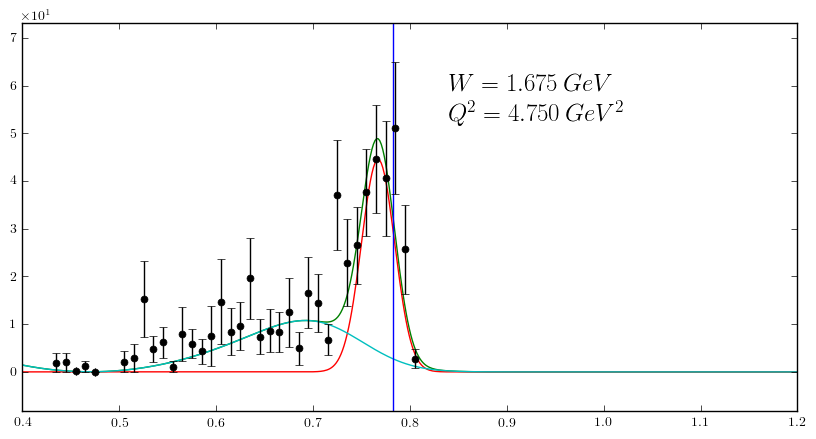

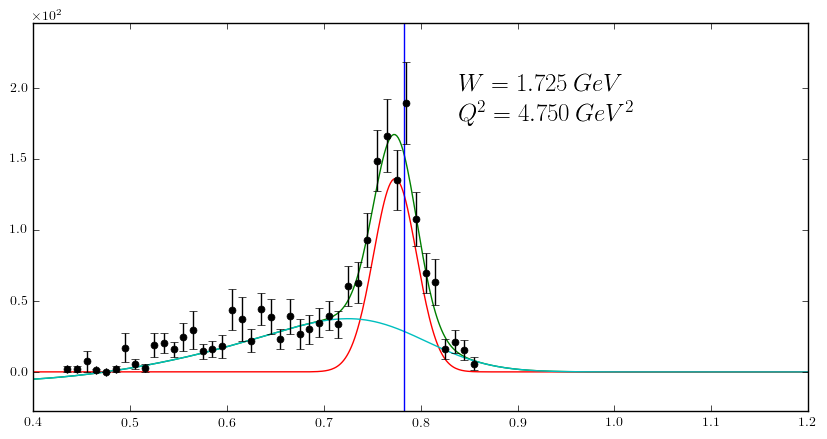

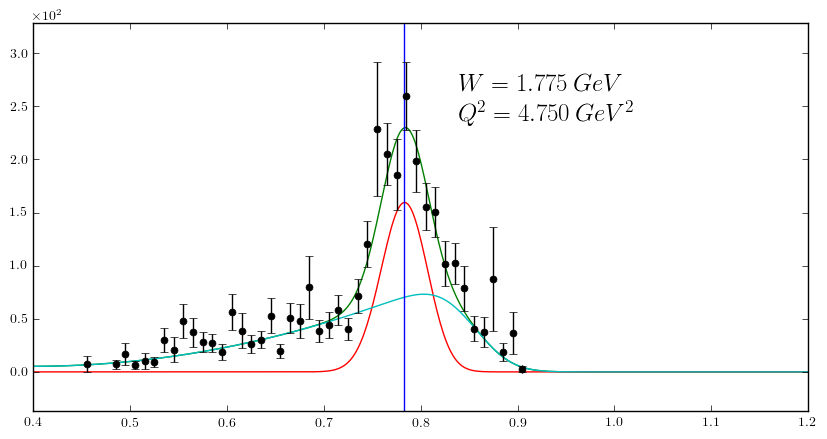

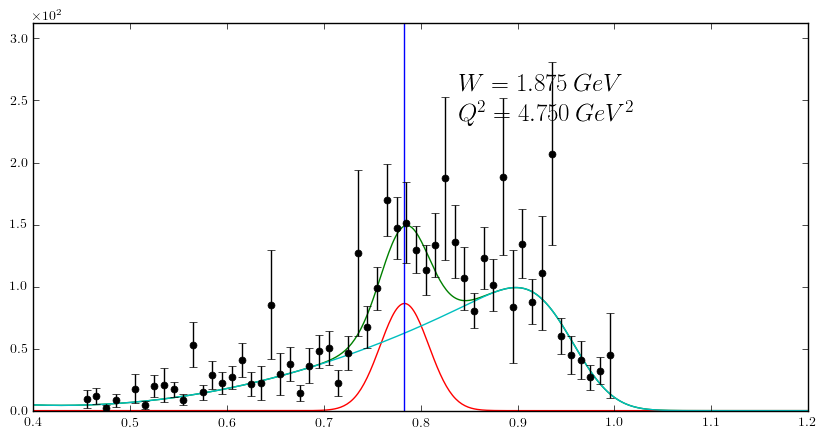

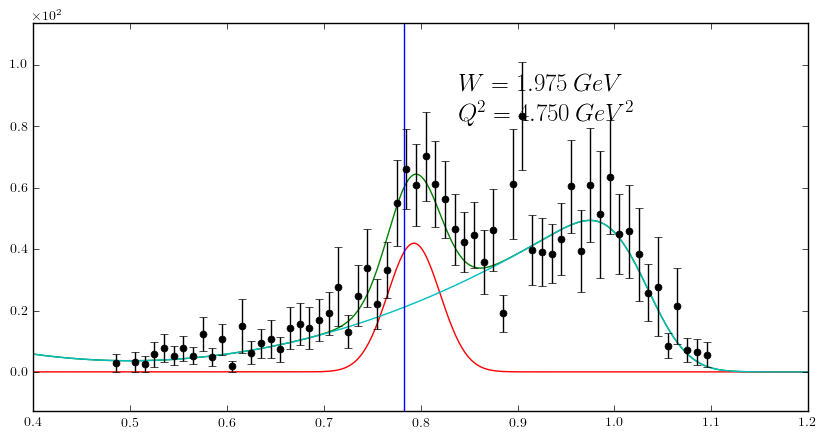

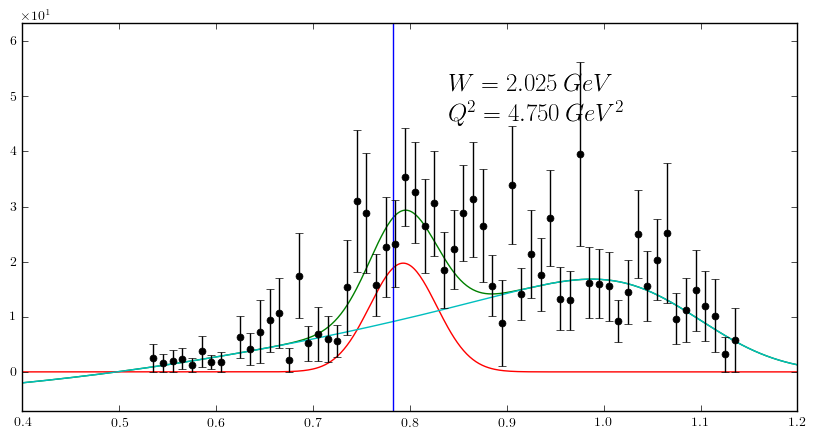

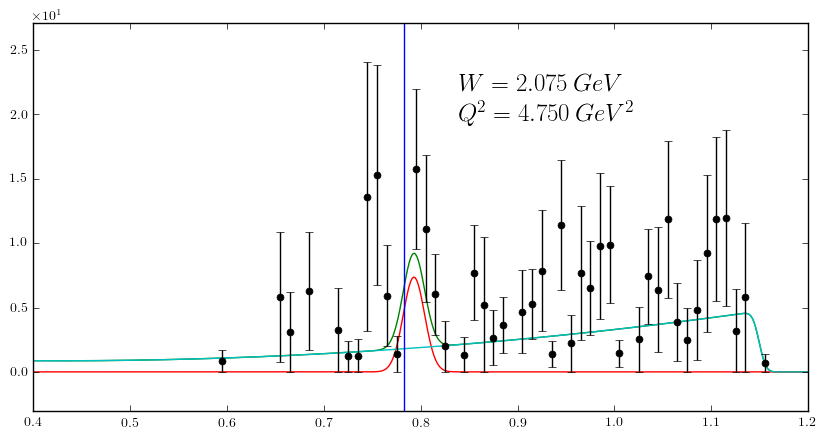

In [21]:
plt.rc('text', usetex=True)
def drawsample(n, hgbs):
    fig = draw(hgbs[n][2])
    plt.plot(np.linspace(0.4,1.2,500), [hgbs[n][3].Eval(x) for x in np.linspace(0.4,1.2,500)])
    fgaus = r.TF1('fgaus', gausdrop, 0.4, 1.2, 5)
    fbg = r.TF1('fbg', bgfun, 0.4, 1.2, 5)
    gpars = hgbs[n][4][5:]+hgbs[n][4][3:5]
    fgaus.SetParameters(r.Double(gpars[0]), r.Double(gpars[1]),
                        r.Double(gpars[2]), r.Double(gpars[3]),
                        r.Double(gpars[4]))
    fbg.SetParameters(*[r.Double(p) for p in hgbs[n][4][0:5]])
    plt.plot(np.linspace(0.4,1.2,500), [fgaus.Eval(x) for x in np.linspace(0.4,1.2,500)])
    plt.plot(np.linspace(0.4,1.2,500), [fbg.Eval(x) for x in np.linspace(0.4,1.2,500)])
    plt.axvline(0.78265)
    plt.text(0.55, 0.75, '$W = %.3f\,GeV$\n$Q^{2} = %.3f\,GeV^{2}$'%(hgbs[n][0],hgbs[n][1]), fontsize=18, transform=fig.axes[0].transAxes)

for n in range(0,len(hgoods)):
    drawsample(n,hgoods)

/home/ephelps/projects/anaconda2/envs/root6_py3/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


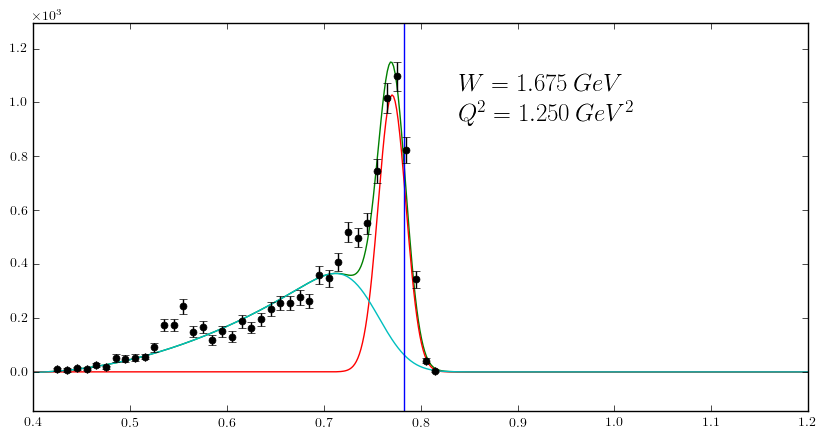

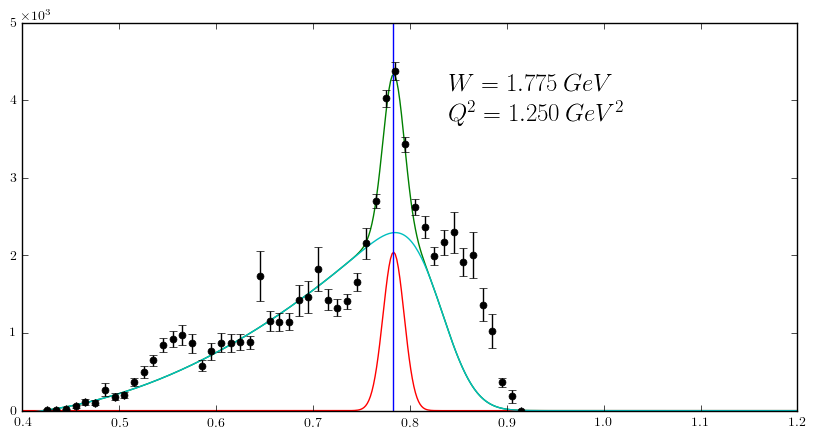

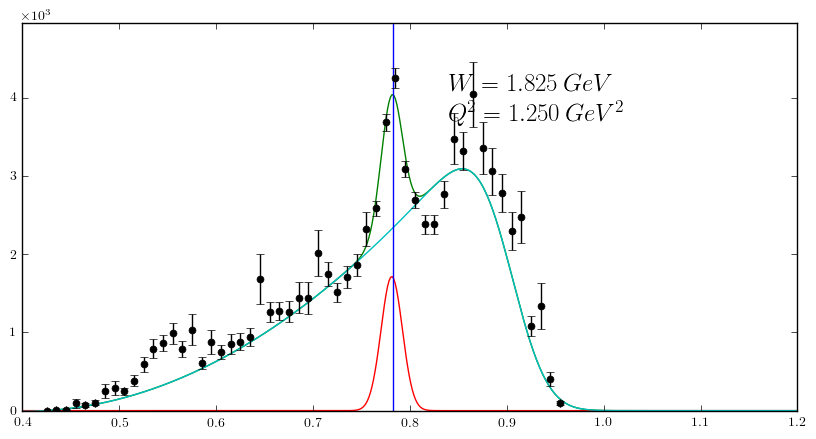

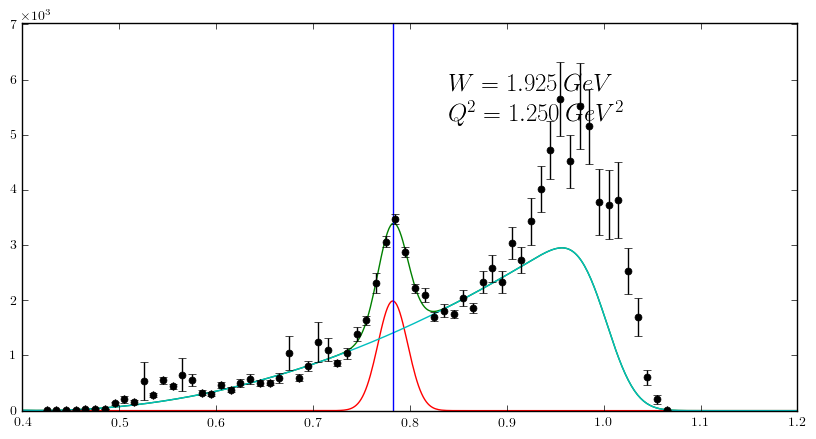

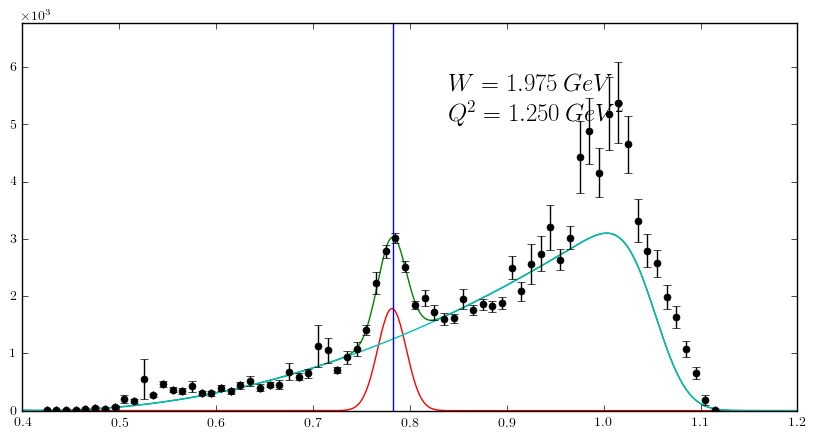

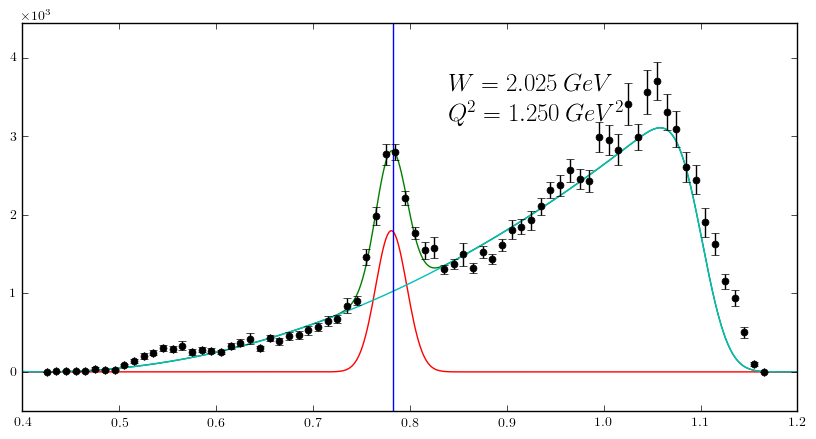

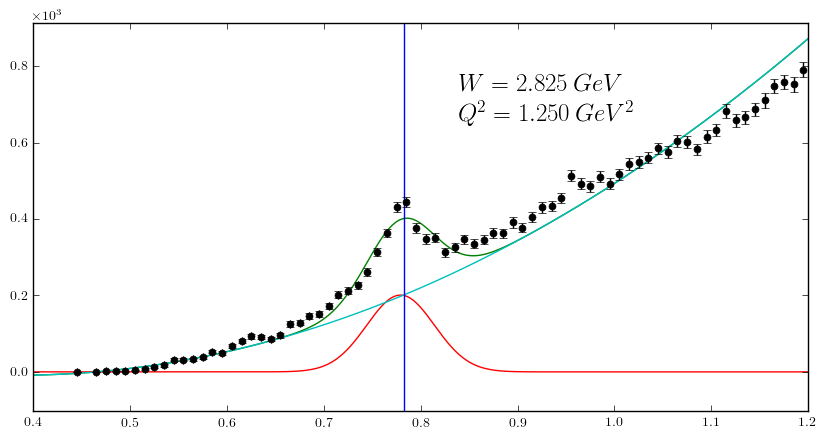

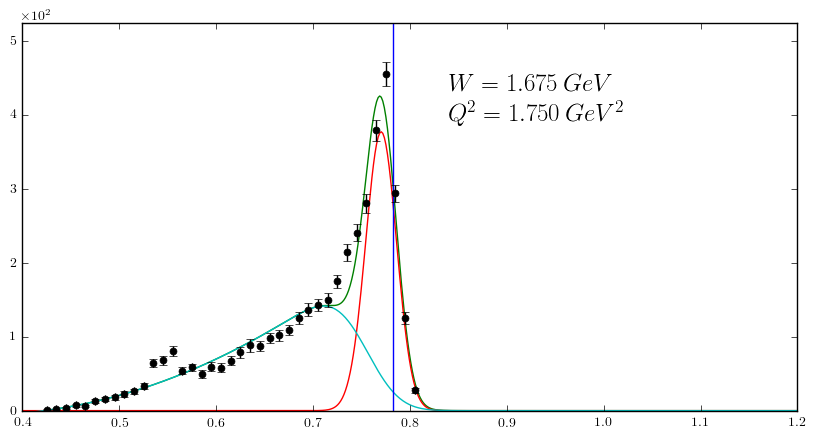

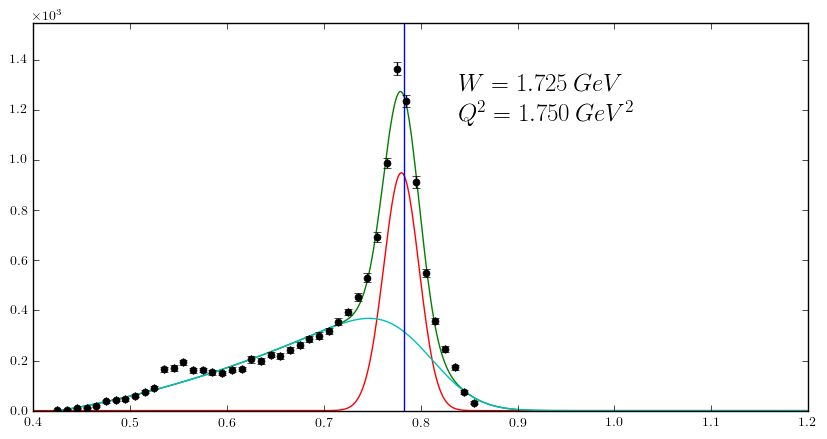

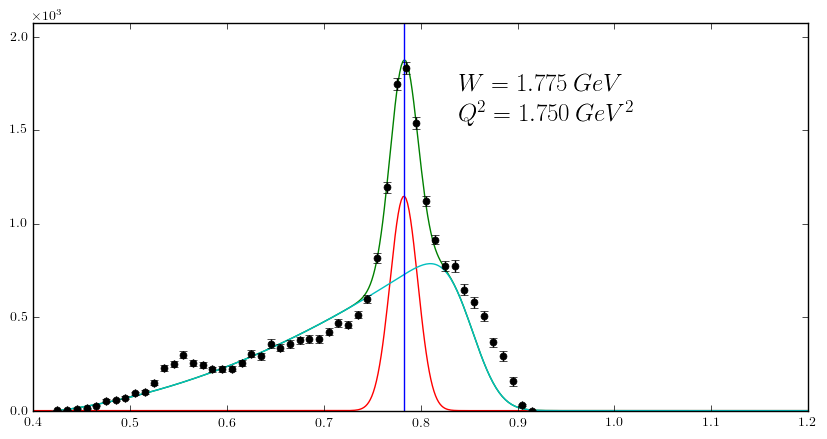

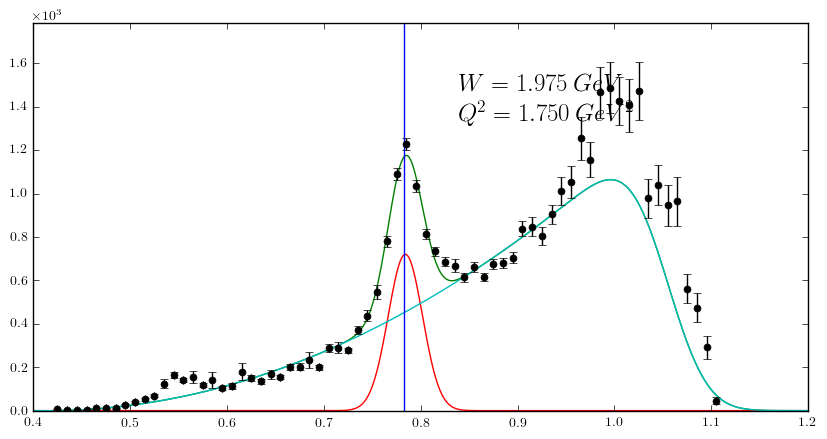

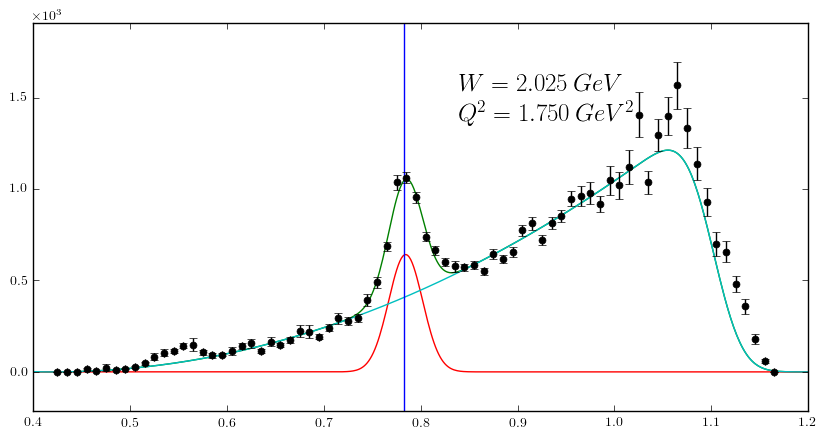

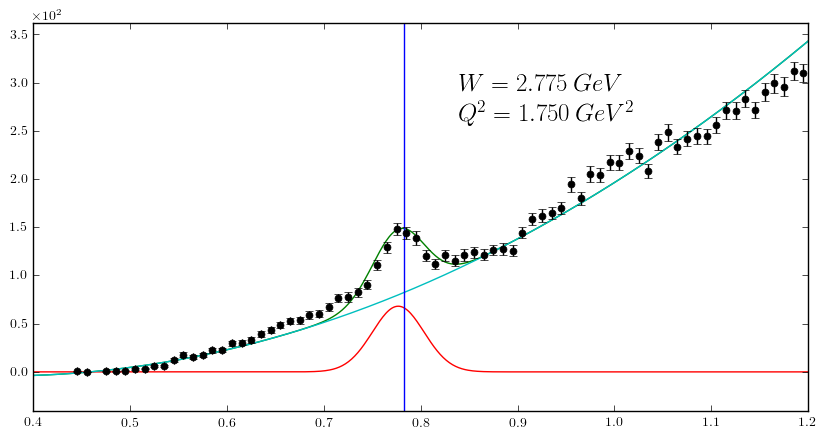

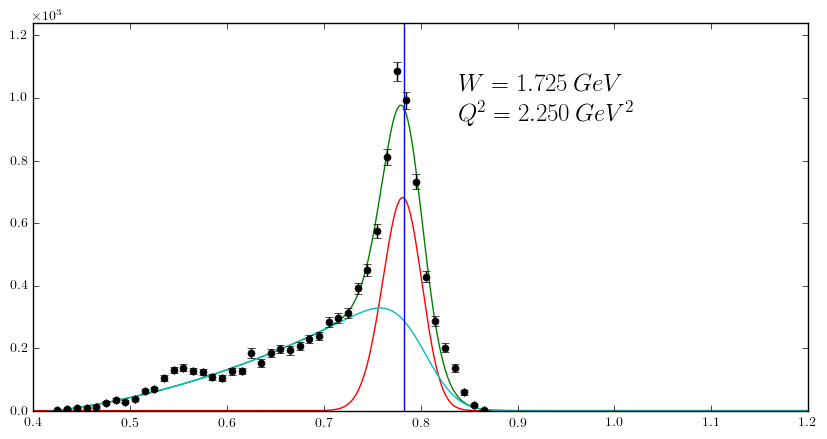

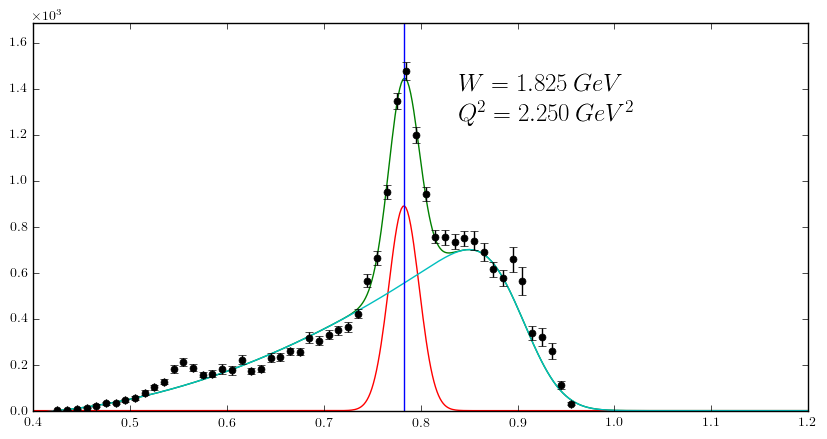

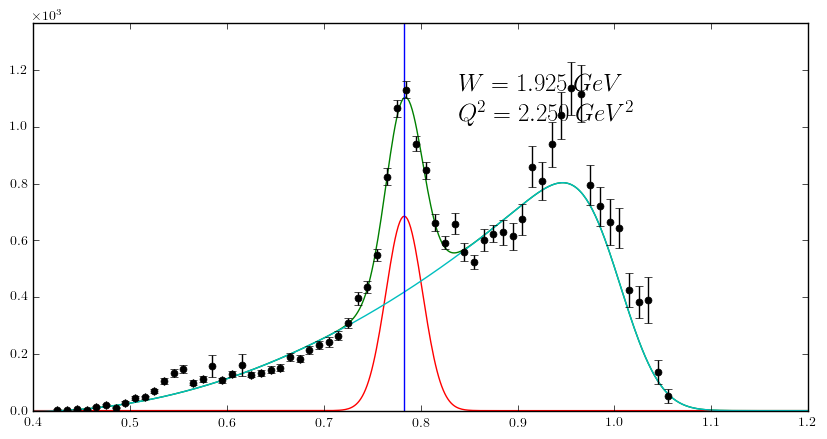

In [21]:
for n in range(0,len(hbads)):
    drawsample(n,hbads)

# Scratch

In [58]:
from functools import reduce
sbedges = [mmp0, mmp1, mmp2, mmp3] = [0.6, 0.74, 0.85, 0.95]
xax = results[0][2].GetXaxis()
sbedges_bins = [bin0, bin1, bin2, bin3] = [xax.FindBin(mmpi) for mmpi in sbedges]
sbedges_bins[-1] += 1
sbedges = [xax.GetBinLowEdge(b) for b in sbedges_bins]
bvals = lambda h, bin0, bin1: [bp.value for bp in h[bin0:bin1]]
def getSBrat(res):
    w, q2, h, pars = res[0], res[1], res[2], res[4]
    fbg = r.TF1('fbg', bgfun, 0.4, 1.2, 5)
    fbg.SetParameters(*[r.Double(p) for p in res[4][0:5]])
    xax = h.GetXaxis()
    bin0, bin1, bin2, bin3 = xax.FindBin(mmp0), xax.FindBin(mmp1), xax.FindBin(mmp2), xax.FindBin(mmp3)
    sbw8 = np.sum(bvals(h,bin0,bin1))+np.sum(bvals(h,bin2+1,bin3+1))
    sgw8 = reduce(fbg.Eval, [h.GetBinCenter(ibin) for ibin in range(bin1,bin2+1)])
    return (w,q2,sbw8/sgw8)

In [23]:
ht1q2w_sb01 = rh1('-t1:Q2:W', hn='ht1q2w_sb01', cutstr='1/vgflux*(mmp>%.3f && mmp<%.3f)'%(sbedges[0],sbedges[1]), binning='(32,1.6,3.2, 9,1.0,5.5, 60,0,6)')
ht1q2w_sg12 = rh1('-t1:Q2:W', hn='ht1q2w_sg12', cutstr='1/vgflux*(mmp>%.3f && mmp<%.3f)'%(sbedges[1],sbedges[2]), binning='(32,1.6,3.2, 9,1.0,5.5, 60,0,6)')
ht1q2w_sb23 = rh1('-t1:Q2:W', hn='ht1q2w_sb23', cutstr='1/vgflux*(mmp>%.3f && mmp<%.3f)'%(sbedges[2],sbedges[3]), binning='(32,1.6,3.2, 9,1.0,5.5, 60,0,6)')

In [24]:
ht1q2w_sg12.xedges(ht1q2w_sg12.GetNbinsX())

3.1500000000000004

In [25]:
#for b in ht1q2w_sg12
# for b in ht1q2w_sg12.bins():
#     print(b.y.center)
#     break
#ht1q2s = rp.plotting.HistStack()

#import pandas as pd

wlos, whis, q2los, q2his, hists = [], [], [], [], []
for wbin, q2bin, wlo, whi, q2lo, q2hi in [(wbin, q2bin,
                    ht1q2w_sg12.xaxis.GetBinLowEdge(wbin),
                    ht1q2w_sg12.xaxis.GetBinUpEdge(wbin),
                    ht1q2w_sg12.yaxis.GetBinLowEdge(q2bin),
                    ht1q2w_sg12.yaxis.GetBinUpEdge(q2bin))
                    for wbin in range(1,ht1q2w_sg12.GetNbinsX()+1)
                    for q2bin in range(1,ht1q2w_sg12.GetNbinsY()+1)]:
    hsig = ht1q2w_sg12.ProjectionZ('ht1sig_w _%d_%d_q2_%d_%d'%(1000*wlo,1000*whi,1000*q2lo,1000*q2hi),
                                  wbin, wbin, q2bin, q2bin)
    hsb1 = ht1q2w_sb01.ProjectionZ('ht1sb1_w _%d_%d_q2_%d_%d'%(1000*wlo,1000*whi,1000*q2lo,1000*q2hi),
                                  wbin, wbin, q2bin, q2bin)
    hsb2 = ht1q2w_sb23.ProjectionZ('ht1sb2_w _%d_%d_q2_%d_%d'%(1000*wlo,1000*whi,1000*q2lo,1000*q2hi),
                                  wbin, wbin, q2bin, q2bin)
    wlos.append(wlo)
    whis.append(whi)
    q2los.append(q2lo)
    q2his.append(q2hi)
    hists.append((asrootpy(hsb1),asrootpy(hsig),asrootpy(hsb2)))

dfmap = {'wlo':wlos, 'whi':whis, 'q2lo':q2los, 'q2hi':q2his, 't1hists':hists}
#     if h2.Integral() > 1000:
#         ht1q2s.Add(h2)

In [26]:
import pandas as pd
df = pd.DataFrame(data=dfmap)

In [27]:
#ht1s_1800 = df.t1hists[df.wlo==1.8]
#['%.2f'%wval for wval in list(ht1q2w_sg12.xedgesl())[::2]]
df['w'] = (df.wlo+df.whi)/2 

In [28]:
# print(len(list(h.xedges())))
# print(len(list(h.bins())))
# print(len(list(h.x())))
#sum(df.wlo==2.0)
df.w.unique()
len(df.t1hists[rd(df.w)==1.725])

9

In [29]:
rd = lambda x: np.round(x,4)
def q2pads(wval):
    fig = np.figure(figsize=(16,16))
    cc = ['b','k','g']
    for cell, hs in enumerate(df.t1hists[rd(df.w)==wval],1): #ht1s_1800,1):
        #fig.add_subplot(3,3,cell)
        for i, h in enumerate(hs):
            if sum(h) > 1000:
                h.SetLineColor(cc[i])
                h.SetMarkerColor(cc[i])
                #errorbar(list(h.x()), list(h), list(h.errors()))
                draw(h, 3, 3, cell, fig=fig)
                #yscale('log')

def sumq2s(wval):
    hs = None
    for htuple in df.t1hists[rd(df.w)==rd(wval)]:
        if hs is None:
            hs = list(htuple)
        else:
            [ht.Add(h) for h, ht in zip(hs,htuple)]
    
    return (wval, hs)

#q2pads(1.825)
ht1samples = [sumq2s(wval) for wval in np.arange(1.625, 2.325, 0.050)]

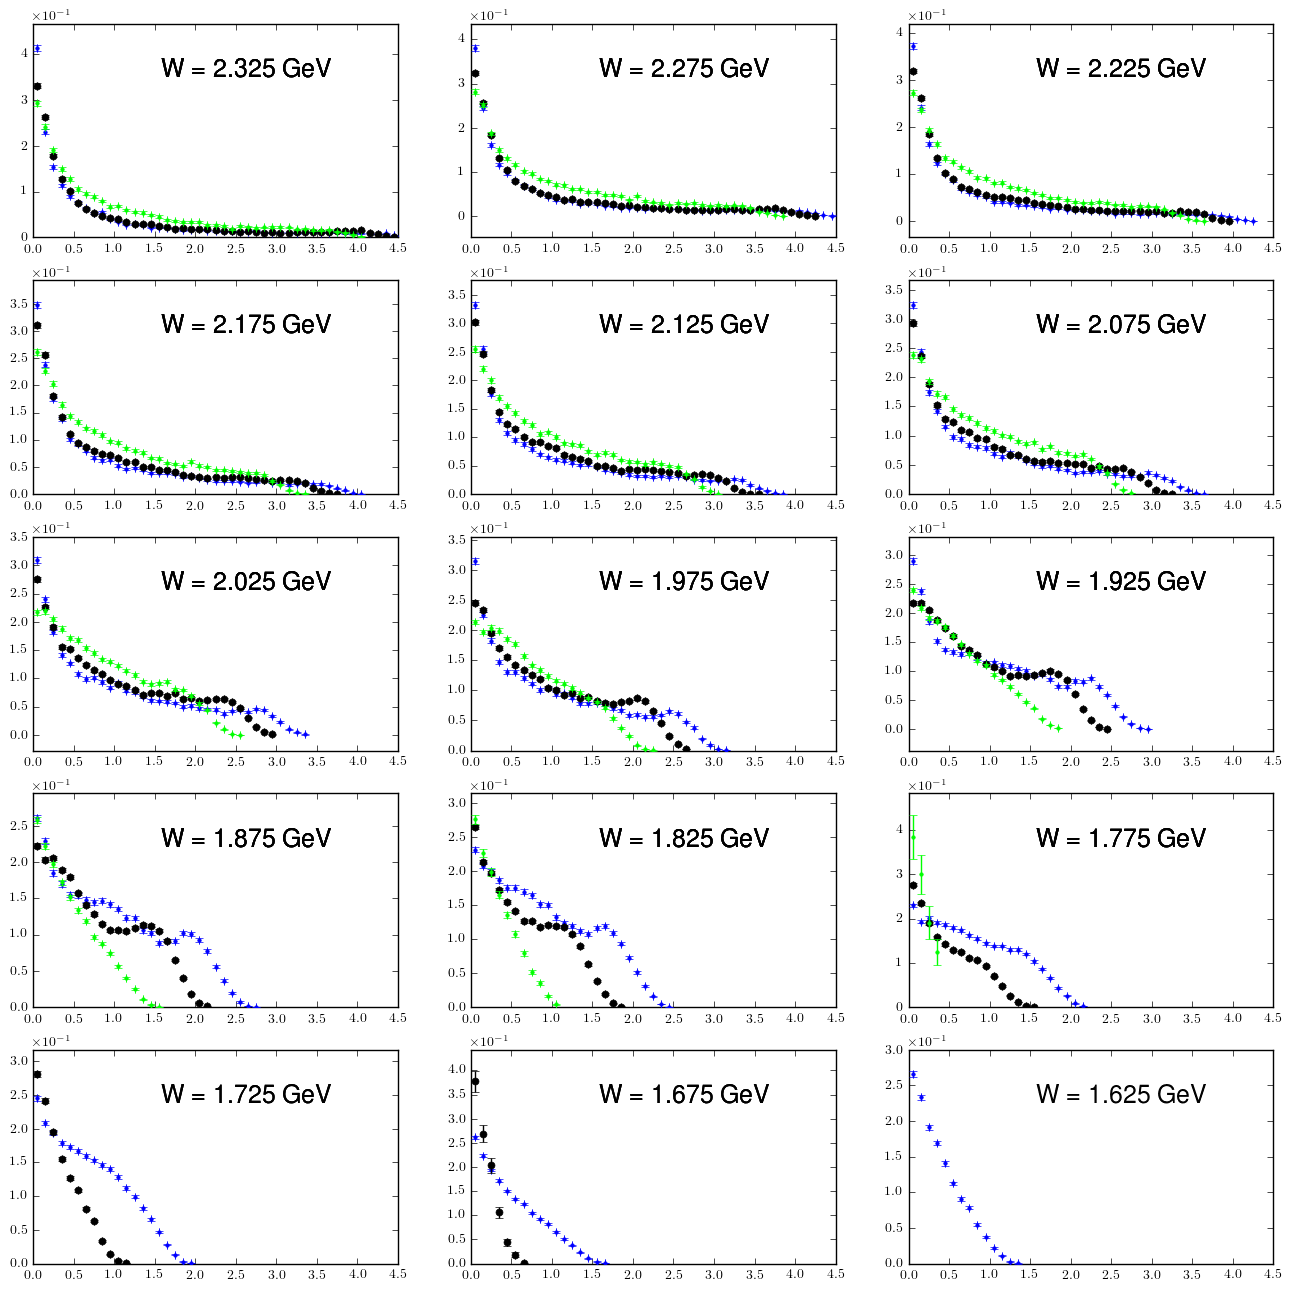

In [65]:
hw2025 = []
fig = plt.figure(figsize=(16,16))
cc = ['b','k','g']
for cell, (wval, hs) in enumerate(reversed(ht1samples),1):
    for i, h in enumerate(hs):
        if h.Integral() > 10:
            h.markerstyle = 20 if i == 1 else 1
            h.color = cc[i]
            h = h.Clone()
            h.Scale(1/h.Integral(1,5))
            draw(h, 3, 5, cell, fig=fig)
            plt.xlim(0,4.5)
            plt.text(0.35, 0.75, 'W = %.3f GeV'%wval, transform = fig.axes[cell-1].transAxes, fontsize=18)
            if round(wval,3)==2.025:
                hw2025.append(h)

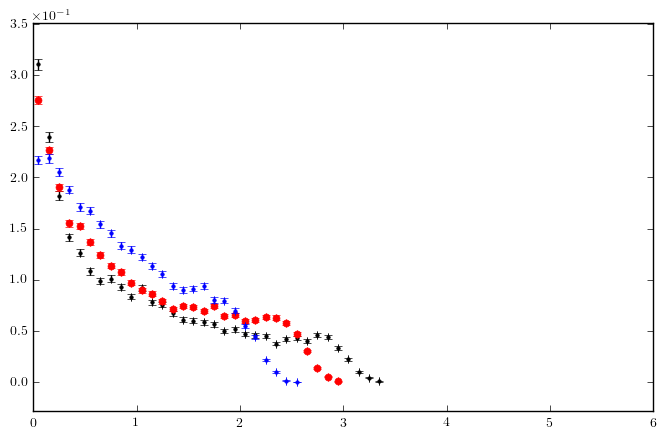

In [66]:
fig = plt.figure(figsize=(8,5))
cc = ['k', 'r','b']
for i, h in enumerate(hw2025):
    h.markerstyle = 20 if i == 1 else 1
    #h.markersize = 1.25 if i == 1 else 1
    h.color = cc[i]
    draw(h, fig=fig)
    
ht1q2w_sb = ht1q2w_sb01+ht1q2w_sb23

In [67]:
hw8s = rp.plotting.Hist3D(32,1.6,3.2, 9,1.0,5.5, 80,0,8)
for res in results:
    for ibint in range(1,hw8s.GetNbinsZ()+1):
        tval = hw8s.GetZaxis().GetBinCenter(ibint)
        hw8s.Fill(r.Double(res[0]),r.Double(res[1]),r.Double(tval), r.Double(getSBrat(res)[2]))
ht1q2w_sb.Divide(hw8s)        
ht1q2w_sig = ht1q2w_sg12-ht1q2w_sb
ht1s = get_projs(ht1q2w, 'ht1_%d_%d', (0.6,0.9), minint=1000)
ht1s_w8d = get_projs(ht1q2w_sig, 'ht1_normd_w8d_%d_%d', (0.6,0.9), minint=1000)

ERROR:ROOT.TH3F.Divide] Cannot divide histograms with different number of bins


NameError: name 'hw2025' is not defined

In [ ]:
hnmatch = lambda x,wval,q2val: x.GetName().find('%s_%s'%(wval,q2val))>=0

In [ ]:
ht1s_both = []
for h1 in ht1s_w8d:
    W, Q2 = h1.GetName().split('_')[-2:]
    htnow8_cands = [h2 for h2 in ht1s if hnmatch(h2,W,Q2)]
    if len(htnow8_cands) != 1:
        raise('%d matches!'%len(htnow8_cands))
    ht1s_both.append((h1,htnow8_cands[0]))

In [ ]:
def drawt1(h, fig):
    #h = ht1s[6]
    W, Q2 = h[0].GetName().split('_')[-2:]
    W = float(W)/1000.0
    Q2 = float(Q2)/1000.0
    fig = draw(h)
    plot(linspace(0,8), [h[0].Interpolate(x) for x in linspace(0,8)])
    f = interpolate.interp1d([h[0].GetBinLowEdge(i+1) for i in range(1,len(h[0])+1)], [h[0][i] for i in range(0,len(h[0]))], kind='cubic')
    text(0.55, 0.75, '$W = %.3f\,GeV$\n$Q^{2} = %.3f\,GeV^{2}$'%(W,Q2), fontsize=18, transform=fig.axes[0].transAxes)

fexpo = r.TF1('fexpo', 'expo', 0, 8)
X = linspace(0,0.6,50)
Xb = linspace(0.6,8,100)
for i, h in enumerate(ht1s_both):
    try:
        W, Q2 = h[0].GetName().split('_')[-2:]
        W = float(W)/1000.0
        Q2 = float(Q2)/1000.0
        fig = figure()
        draw(h[0], fig=fig)
        draw(h[1], fig=fig)
        text(0.55, 0.75, '$W = %.3f\,GeV$\n$Q^{2} = %.3f\,GeV^{2}$'%(W,Q2), fontsize=18, transform=fig.axes[0].transAxes)
        text(0.55, 0.3, 'idx = %d'%i, fontsize=18, transform=fig.axes[0].transAxes)
        h[0].Fit(fexpo, 'N0', 'goff', 0.1, 0.8)
        plot(X, [fexpo.Eval(x) for x in X])
        pars = [fexpo.GetParameter(0),fexpo.GetParameter(1)]
        h[1].Fit(fexpo, 'N0', 'goff', 0.1, 0.8)
        pars = pars + [fexpo.GetParameter(0),fexpo.GetParameter(1)]
        plot(X, [fexpo.Eval(x) for x in X])
        text(0.35, 0.4, '%.3f, %.3f\n...\n%.3f, %.3f'%(pars[0],pars[1],pars[2],pars[3]), fontsize=18, transform=fig.axes[0].transAxes)
        plot(Xb, [h[0].interpolate(x) for x in Xb])
        plot(Xb, [h[1].interpolate(x) for x in Xb])
    except:
        pass

In [ ]:
ht1s_both[23][1].Draw()

In [ ]:
if not r.TMath.Finite(ht1s_both[23][0].GetBinContent(81)):
    print(ht1s_both[23][0].GetBinContent(0))

In [ ]:
plot(linspace(0.4,2), [1-math.erf((x-1)/0.2) for x in linspace(0.4,2)])

# proton momentum distributions

Hadron energy loss mechanisms are more relevant for low-momentum hadrons, making proton energy loss more relevant for higher $Q^2$ and lower $W$. However, $\pi^{+}$ momenta are generally low, so energy loss correction may be mandatory for pions.

In [ ]:
hpq2w_p_omega = rh1('p[h10idx_p]:Q2:W', hn='hpq2w_p_omega', cutstr='1/vgflux*(mmp>0.74 && mmp<0.85)', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')
hpq2w_p_not_omega = rh1('p[h10idx_p]:Q2:W', hn='hpq2w_p_notomega', cutstr='1/vgflux*((mmp>0.6 && mmp<0.74) || (mmp>0.85 && mmp<0.975))', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')
hpq2w_p = rh1('p[h10idx_p]:Q2:W', hn='hpq2w_p', cutstr='1/vgflux', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')

In [ ]:
hpq2w_p_cm = rh1('pf.p1.P():Q2:W', hn='hpq2w_p_cm', cutstr='1/vgflux', binning='(32,1.6,3.2, 9,1.0,5.5, 260, 0.0, 1.3)')

In [ ]:
hpq2w_p_cm_omega = rh1('pf.p1.P():Q2:W', hn='hpq2w_p_cm_omega', cutstr='1/vgflux*(mmp>0.74 && mmp<0.85)', binning='(32,1.6,3.2, 9,1.0,5.5, 260, 0.0, 1.3)')

In [ ]:
hpq2w_p_s1 = rh1('p[h10idx_p]:Q2:W', hn='hpq2w_p_s1', cutstr='1/vgflux*(sc_sect[sc[h10idx_p]]==1)', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')

In [ ]:
hpq2w_p_s4 = rh1('p[h10idx_p]:Q2:W', hn='hpq2w_p_s4', cutstr='1/vgflux*(sc_sect[sc[h10idx_p]]==4)', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')

In [ ]:
hpq2w_pip_omega = rh1('p[h10idx_pip]:Q2:W', hn='hpq2w_pip_omega', cutstr='1/vgflux*(mmp>0.74 && mmp<0.85)', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')
hpq2w_pip_not_omega = rh1('p[h10idx_pip]:Q2:W', hn='hpq2w_pip_notomega', cutstr='1/vgflux*((mmp>0.6 && mmp<0.74) || (mmp>0.85 && mmp<0.975))', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')
hpq2w_pip = rh1('p[h10idx_pip]:Q2:W', hn='hpq2w_pip', cutstr='1/vgflux', binning='(32,1.6,3.2, 9,1.0,5.5, 100, 0.0, 4.0)')

In [ ]:
hpq2w_e = rh1('p[0]:Q2:W', hn='hpq2w_e', cutstr='1/vgflux', binning='(32,1.6,3.2, 9,1.0,5.5, 220, 0.0, 5.5)')

In [ ]:
hp_ep = rh1('p[h10idx_p]:p[0]', hn='hp_ep', cutstr='1/vgflux', binning='(100,0.683,4.1831,100,0,4)')

In [ ]:
def gethps(hpq2w):
    wax, q2ax, pax = hpq2w.GetXaxis(), hpq2w.GetYaxis(), hpq2w.GetZaxis()
    hps = []
    for q2bin in range(1, q2ax.GetNbins()+1):
        q2val = q2ax.GetBinCenter(q2bin)
        if q2val > 1.5:
            q2ax.SetRange(q2bin,q2bin+1)
            h = asrootpy(hpq2w.Project3D('zx'))
            h.SetName('%s_p_%d'%(hpq2w.GetName(),q2val))
            hps.append((q2val,h))
    q2ax.SetRange(0,-1)
    return hps

In [ ]:
hps2 = gethps(hpq2w_p)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)
    
hps2b = gethps(hpq2w_p_omega)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2b):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)
    
hps2c = gethps(hpq2w_p_not_omega)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2c):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)

In [ ]:
hps2_s1 = gethps(hpq2w_p_s1)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2_s1):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)

hps2_s4 = gethps(hpq2w_p_s4)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2_s4):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)

In [ ]:
hps = gethps(hpq2w_e)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps):
    draw(h[1], 4, 2, i+1, fig=fig)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)

In [ ]:
fig = figure()
fig = draw(hp_ep)

In [ ]:
hps2pip = gethps(hpq2w_pip)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2pip):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)
    
hps2pipb = gethps(hpq2w_pip_omega)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2pipb):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)
    
hps2pipc = gethps(hpq2w_pip_not_omega)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2pipc):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)

In [ ]:
hps2cm = gethps(hpq2w_p_cm)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2cm):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)

hps2cm_omega = gethps(hpq2w_p_cm_omega)
fig = figure(figsize=(16,8))
for i, h in enumerate(hps2cm_omega):
    draw(h[1], 4, 2, i+1, fig=fig)
    axvline(1.721)
    #axvline(1.721+0.139)
    axvline(0.938+0.958)
    text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%h[0], fontsize=18, transform=fig.axes[i].transAxes)

In [ ]:
hpq2w_p = asrootpy(hpq2w_p)
hpq2w_p.GetYaxis().SetRange(3,3)

In [ ]:
h2pw = asrootpy(hpq2w_p.Project3D('zx'))

In [ ]:
fig = draw(h2pw)

In [ ]:
h2pw.Draw('logcolz')

In [ ]:
h10.SetEntryList(el3)

In [ ]:
e0 = 5.497
mp = 0.938
h10.Draw("2*p[0]*%.3f*(1-cz[0]):sqrt(-2*p[0]*%.3f*(1-cz[0])+%.3f**2+2*(%.3f-p[0])*%.3f)>>hq2w_top3(80,1.6,3.2,55,0,5.5)"%(e0,e0,mp,e0,mp),"","colz")

In [ ]:
h10.Draw("-2*%.3f*(%.3f-p[0])>>ht_top3(600,0,6)"%(mp,mp), "1/vgflux")

In [ ]:
h10.Draw("-2*%.3f*(%.3f-p[0]):2*p[0]*%.3f*(1-cz[0]):sqrt(-2*p[0]*%.3f*(1-cz[0])+%.3f**2+2*(%.3f-p[0])*%.3f)>>htq2w_top3(80,1.6,3.2,11,0,5.5,600,0,6)"%(mp,mp,e0,e0,mp,e0,mp),"","")
htq2w_top3 = asrootpy(r.gROOT.FindObject('htq2w_top3'))

In [ ]:
thists = np.empty((htq2w_top3.GetNbinsY(),htq2w_top3.GetNbinsX()),dtype=object)

In [ ]:
for q2bin in range(0,len(thists[:,1])):
    for wbin in range(0,len(thists[0])):
        htq2w_top3.GetXaxis().SetRange(wbin,wbin+1)
        htq2w_top3.GetYaxis().SetRange(q2bin,q2bin+1)
        ht = asrootpy(htq2w_top3.Project3D('z'))
        if ht.Integral()>1000:
            thists[q2bin][wbin] = ht
            thists[q2bin][wbin].SetName('t_%d_%d'%(wbin,q2bin))

In [ ]:
hts = [h for h in thists[q2bin][wbin] for q2bin in range(0,len(thists[:,1])) for wbin in range(0,len(thists[0])) if thists[q2bin][wbin].Integral()>1000]